# Created Trained Threshold DF

Adjusted from 2024-02-14 Create Trained Threshold

**Goal** Given training curve analysis, implement thresholds to created a "trained" dataset for each animal.

For model fitting, since we are fitting a non-dynamic model, it makes the most sense to start by looking only at trials when an animal is trained and performing the task. Determining how to set this threshold, and what the outcome of different approaches are will be formally explored in this notebook.

Related notebooks

- `2024_02_14_explore_trained_threshold.ipynb`
- `eda.ipynb`


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from violmulti.data.dataset_loader import *
from violmulti.data.dataset_thresholder import *
import config as c

sns.set_context("talk")
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = DatasetLoader(data_type="new_all").load_data()

DataLoader: Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']


In [3]:
pt = PerformanceThresholder()

## Hits

First, I will start by explore the hit rate and how it changes over time. I've written a PerformanceThresholder class to store out information and I will be using that. The general things to note is the data_dict has two primary keys "hit" and "violation" where respective data is stored.

My hypothesis based off the initial eda.ipynb is that using the crossing from low -> high over a performance threshold will be a good metric for determining when an animal is trained. In the previous notebook I used the last crossing of the 70% threshold of a rolling 14 day hit rate.

Here I want to explore: rolling window sizes, thresholds, and if min/median/max crossing (or something else) is the best to use. Lets start with window sizes.


In [4]:
_ = pt.compute_rolling_means_iter_window(df, "hit", window_sizes=[7, 14, 21, 28])

pt.data_dict["hit"]["rolling_mean_windows_df"].head()

,animal_id,session,training_stage,hit,rolling_mean_hit,window_size
0,W051,1,1,0.832869,0.832869,7
1,W051,2,1,0.938356,0.885613,7
2,W051,3,1,0.981013,0.917413,7
3,W051,4,1,0.992727,0.936241,7
4,W051,5,1,1.000000,0.948993,7


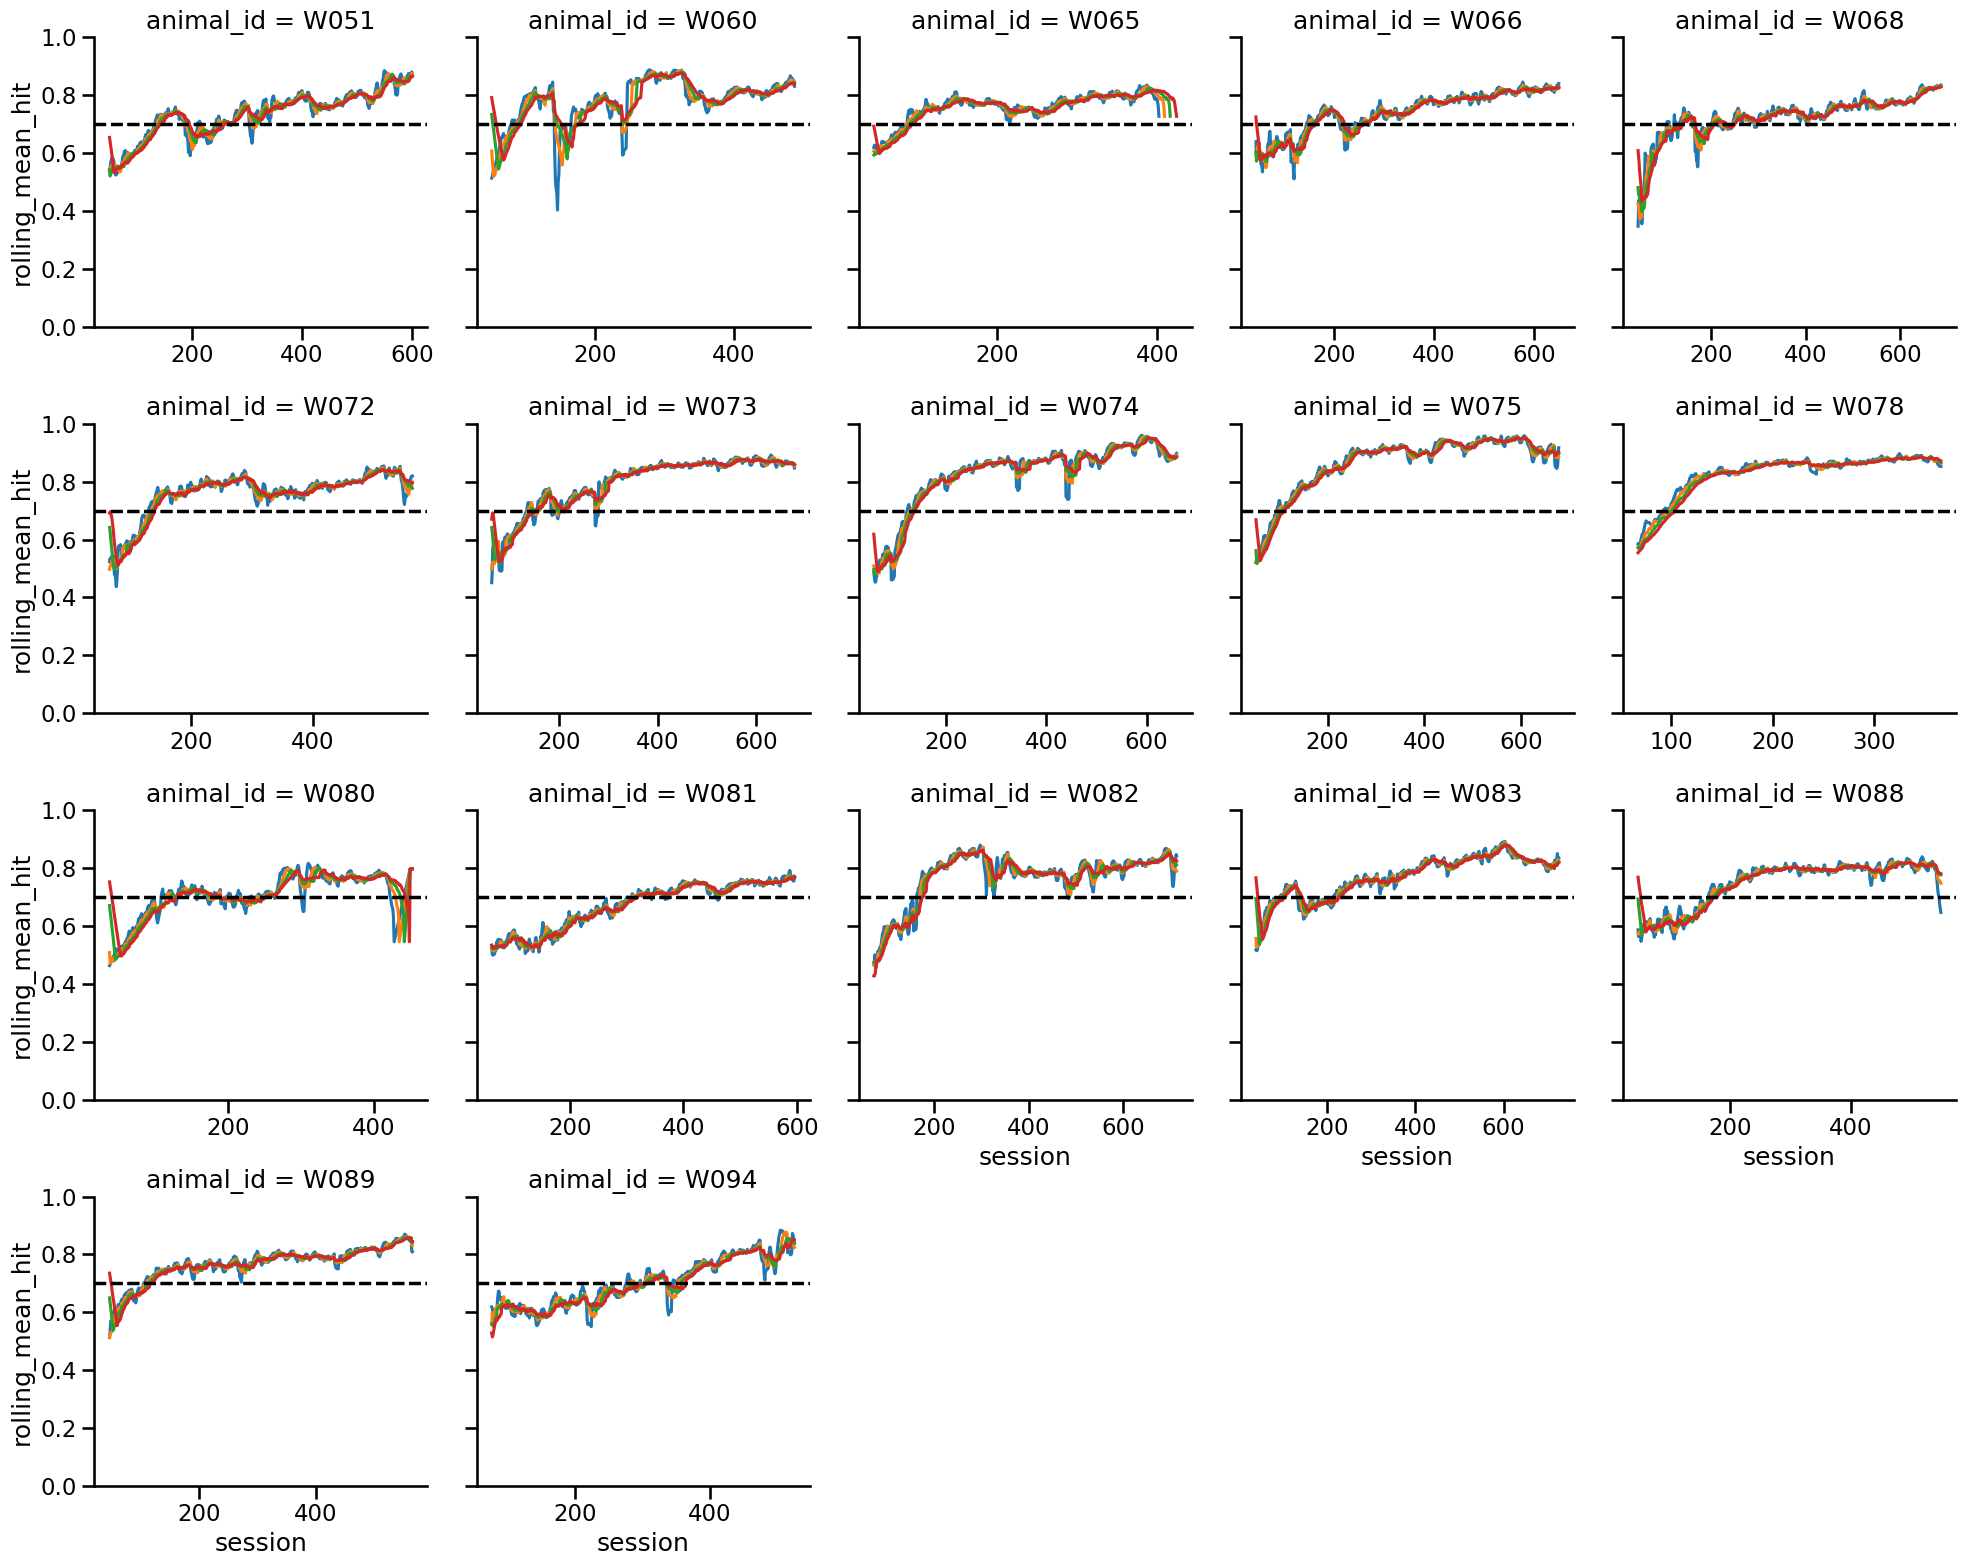

In [5]:
g = sns.FacetGrid(
    data=pt.data_dict["hit"]["rolling_mean_windows_df"].query("training_stage > 3"),
    col="animal_id",
    col_wrap=5,
    hue="window_size",
    height=4,
    sharex=False,
)
g.map(sns.lineplot, "session", "rolling_mean_hit")
g.map(plt.axhline, y=0.7, color="black", linestyle="--")
g.set(ylim=(0, 1))

The rolling mean on hit rate seems track well. I think 7 days is not smooth enough and 28 days is a bit too smooth. I want to find the changes in the hit rate after they happen, i.e. being delayed a few sessions is a good thing because the animal will be more trained. I'm going to work with a window size of 21 for now.

**Next step**: lets see if first, median or max crossing works the best.


In [6]:
threshold = 0.70
window_size = 21
hit_70_threshold = pt.calculate_threshold_crossings(
    df=pt.data_dict["hit"]["rolling_mean_windows_df"],
    column="hit",
    window_size=window_size,
    threshold=threshold,
)

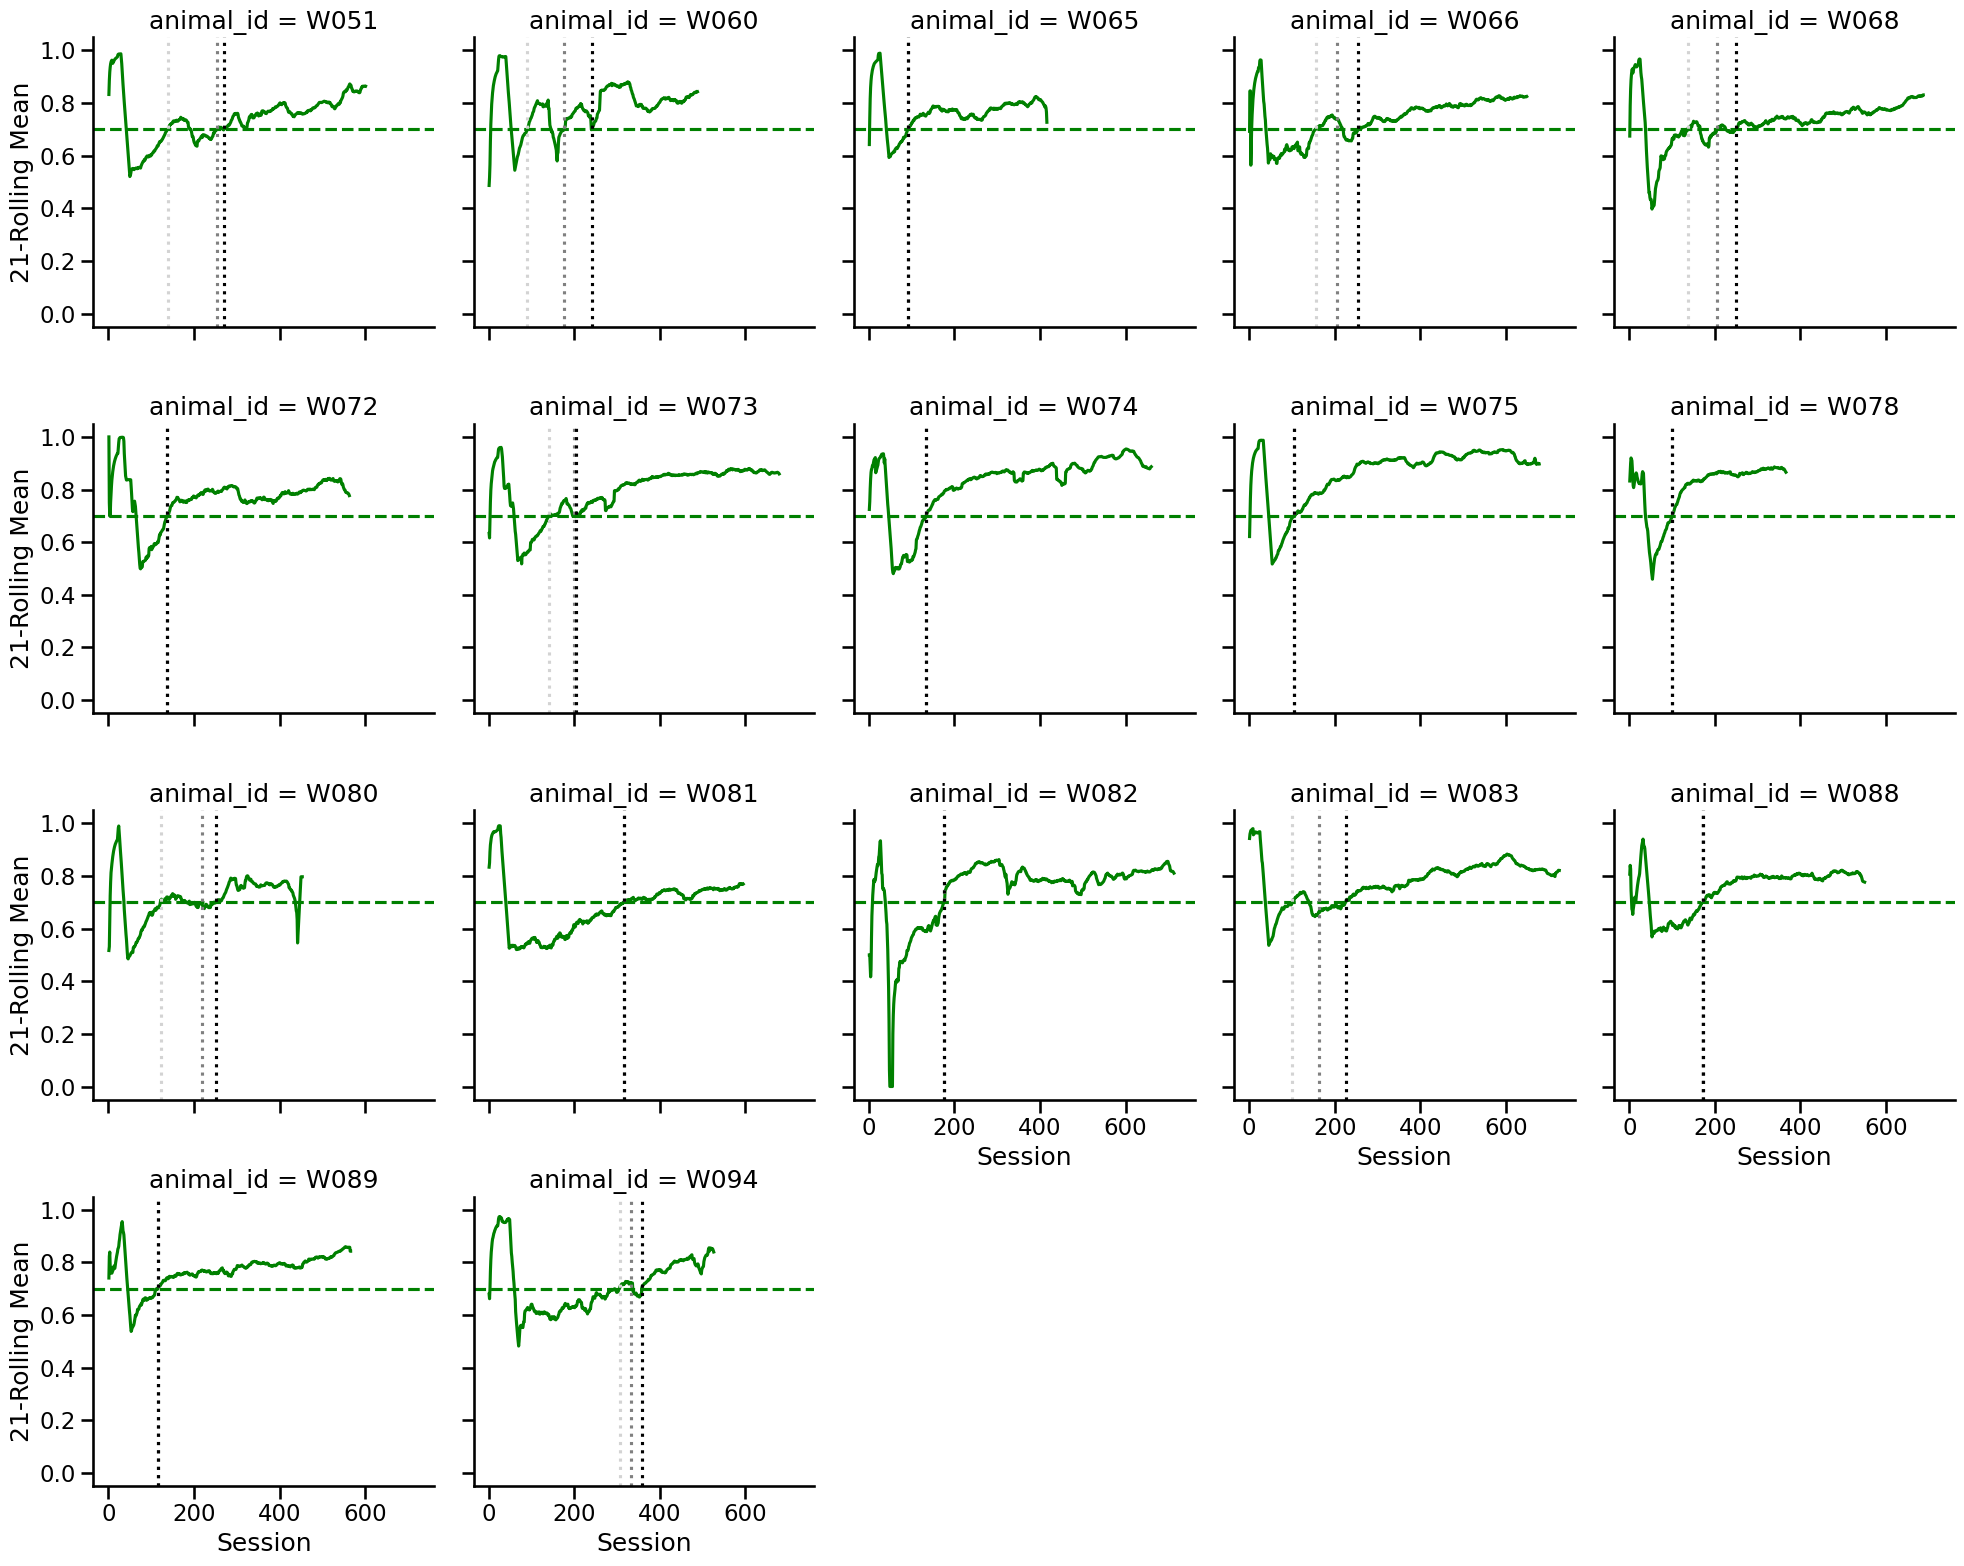

In [7]:
hit_rolling_mean = pt.data_dict["hit"]["rolling_mean_windows_df"].query(
    "window_size == @window_size"
)

# # Create the facet grid plot

g = sns.FacetGrid(
    data=hit_rolling_mean,
    col="animal_id",
    col_wrap=5,
    height=4,
)
g.map(sns.lineplot, "session", "rolling_mean_hit", color="green")
g.map(plt.axhline, y=threshold, color="green", linestyle="--")


for ii, ax in enumerate(g.axes.flat):
    ax.axvline(
        x=hit_70_threshold["min_cross_sess"][ii], color="lightgray", linestyle=":"
    )
    ax.axvline(x=hit_70_threshold["med_cross_sess"][ii], color="gray", linestyle=":")
    ax.axvline(x=hit_70_threshold["max_cross_sess"][ii], color="black", linestyle=":")

g.set_axis_labels("Session", f"{window_size}-Rolling Mean")

Okay- it looks like the last crossing seems to be a good marker for this threshold (70%). I want to move forward with using this. In other words, the logic to start grabbing usable data is "grab everything after the last low -> high crossing over the hit threshold.

Side note: I thinking "W061" and "W062" will not be included from this analysis long term. They don't even make it to 70% threshold and chance when using an sb only rule is ~66% So, I wouldn't say they are doing the task.

**Next Step**: Lets see what crossing thresholds work best.


In [8]:
hit_thresholds = [0.70, 0.71, 0.725, 0.74, 0.75]

_ = pt.compute_crossings_iter_thresholds(
    df=pt.data_dict["hit"]["rolling_mean_windows_df"],
    column="hit",
    window_size=window_size,
    thresholds=hit_thresholds,
)

pt.data_dict["hit"]["crossing_thresholds_df"].head()

,animal_id,crossed_threshold_count,threshold,min_cross_sess,med_cross_sess,max_cross_sess,window_size,type
0,W051,3,0.7,139,254.0,271,21,hit
1,W060,3,0.7,90,176.0,241,21,hit
2,W065,1,0.7,91,91.0,91,21,hit
3,W066,2,0.7,156,205.5,255,21,hit
4,W068,3,0.7,136,205.0,249,21,hit


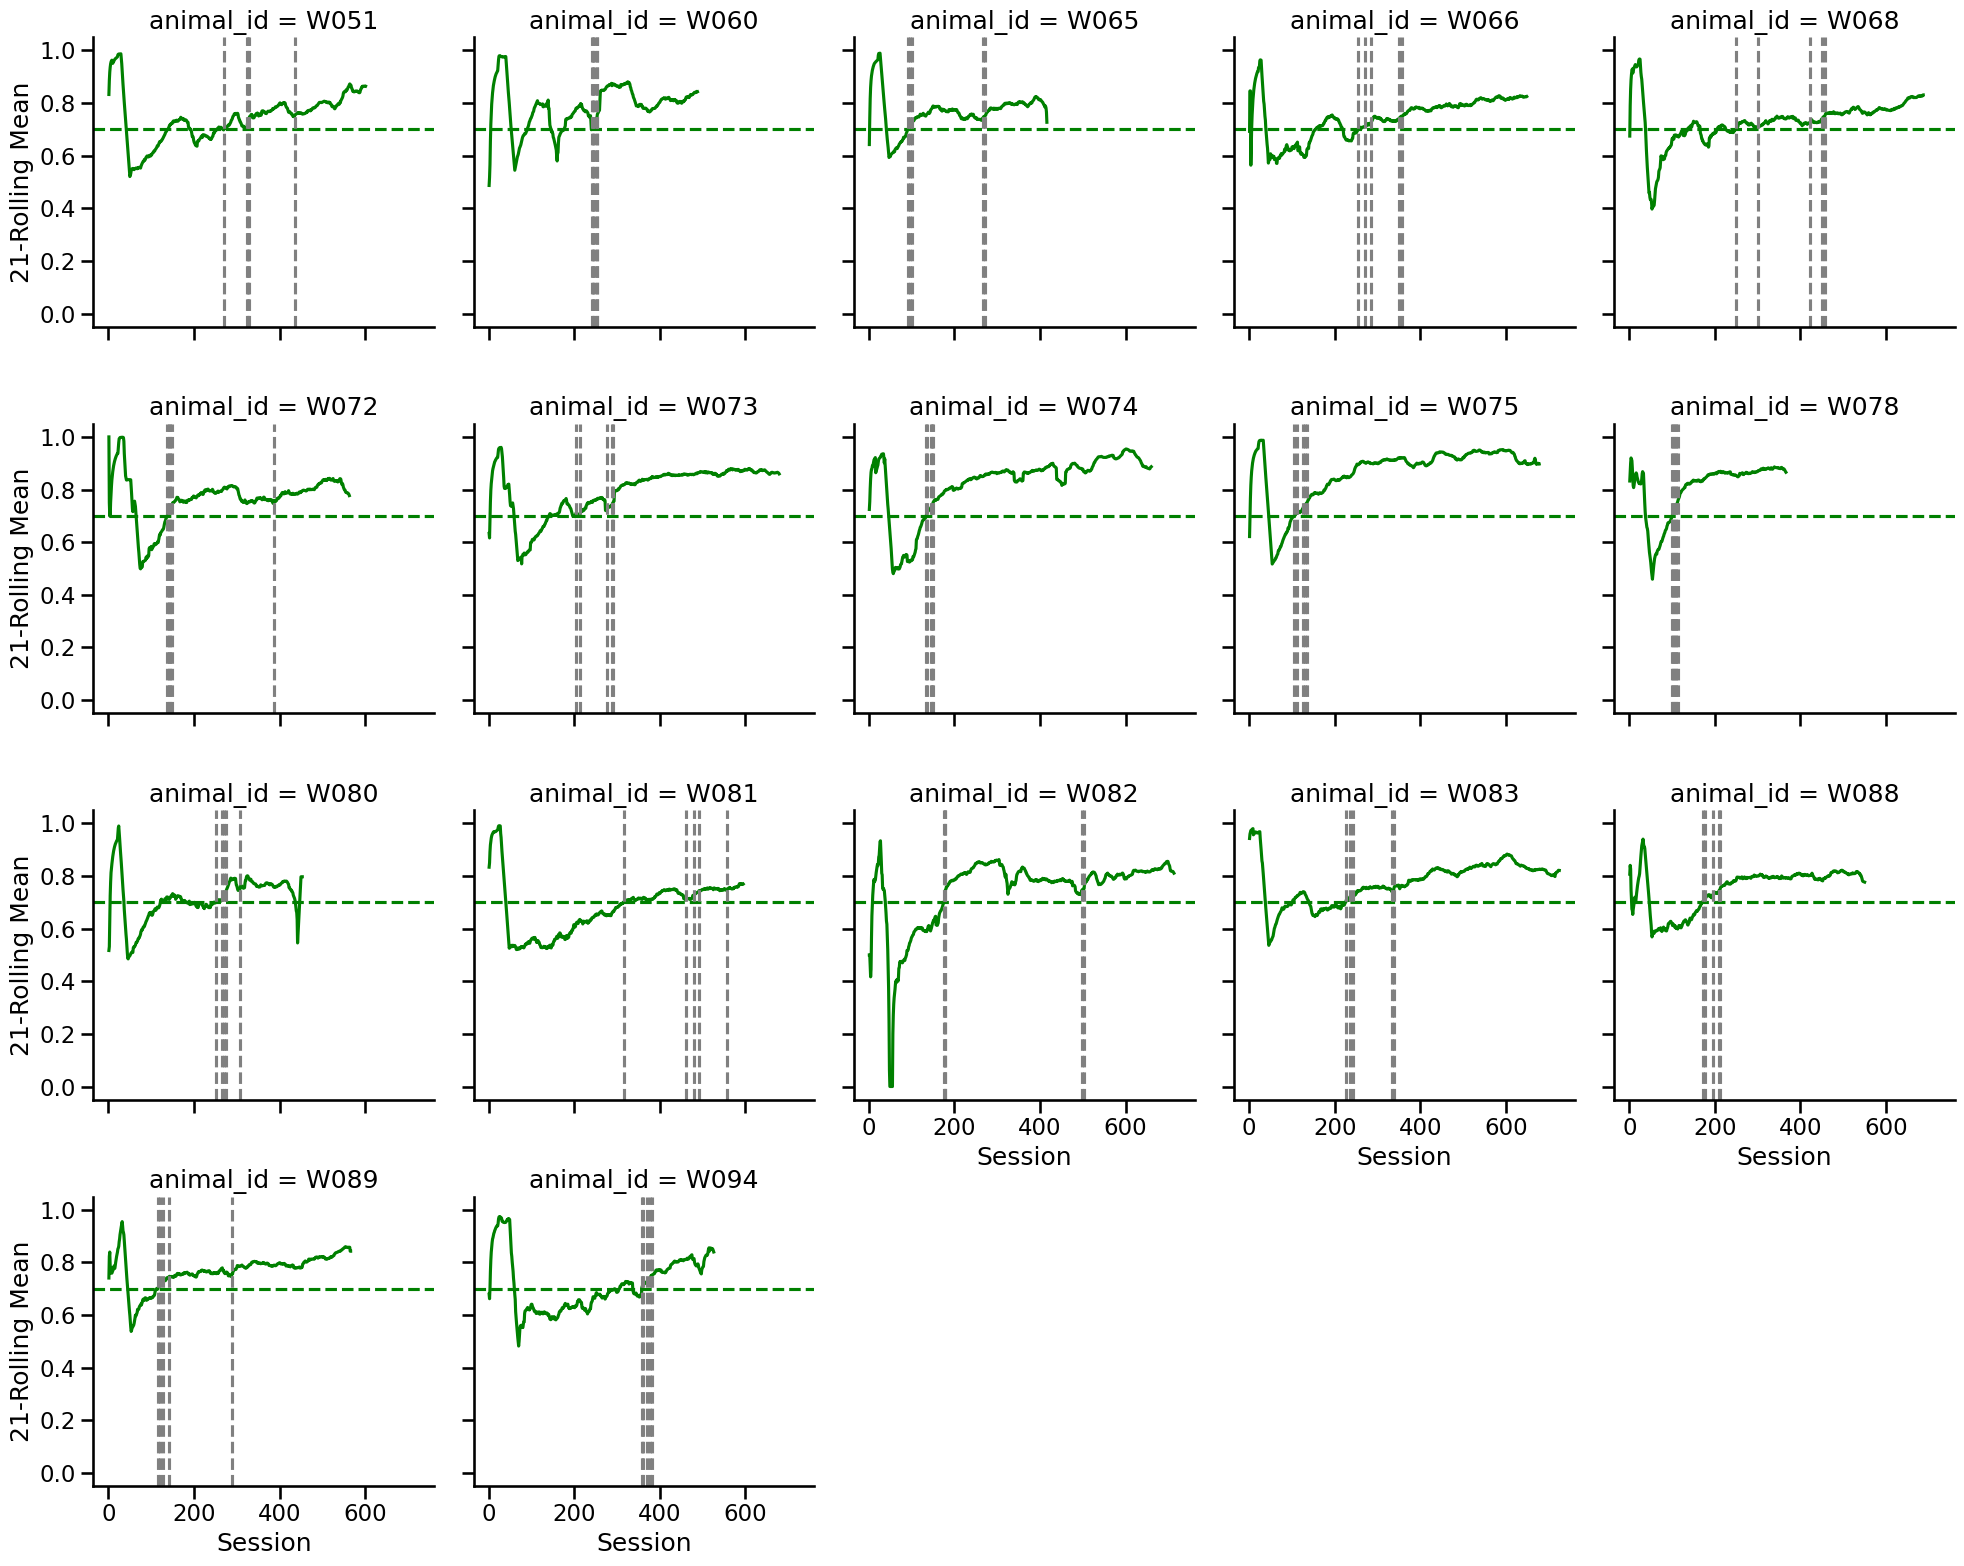

In [9]:
hit_rolling_mean = pt.data_dict["hit"]["rolling_mean_windows_df"].query(
    "window_size == @window_size"
)

# # Create the facet grid plot

g = sns.FacetGrid(
    data=hit_rolling_mean,
    col="animal_id",
    col_wrap=5,
    height=4,
)
g.map(sns.lineplot, "session", "rolling_mean_hit", color="green")
g.map(plt.axhline, y=0.7, color="green", linestyle="--")
for ii, ax in enumerate(g.axes.flat):
    for threshold in hit_thresholds:
        threshold_df = (
            pt.data_dict["hit"]["crossing_thresholds_df"]
            .query("threshold == @threshold")
            .reset_index()
        )

        ax.axvline(
            x=threshold_df["max_cross_sess"][ii],
            color="gray",
            linestyle="--",
        )


g.set_axis_labels("Session", f"{window_size}-Rolling Mean")

For some animals the min and max change a lot. It does seem like there is quite a difference between 0.74 and 0.75 in some animals. In general, 0.75 seems a little high. Lets minimize the range to just be 0.70, 0.725 and 0.75.


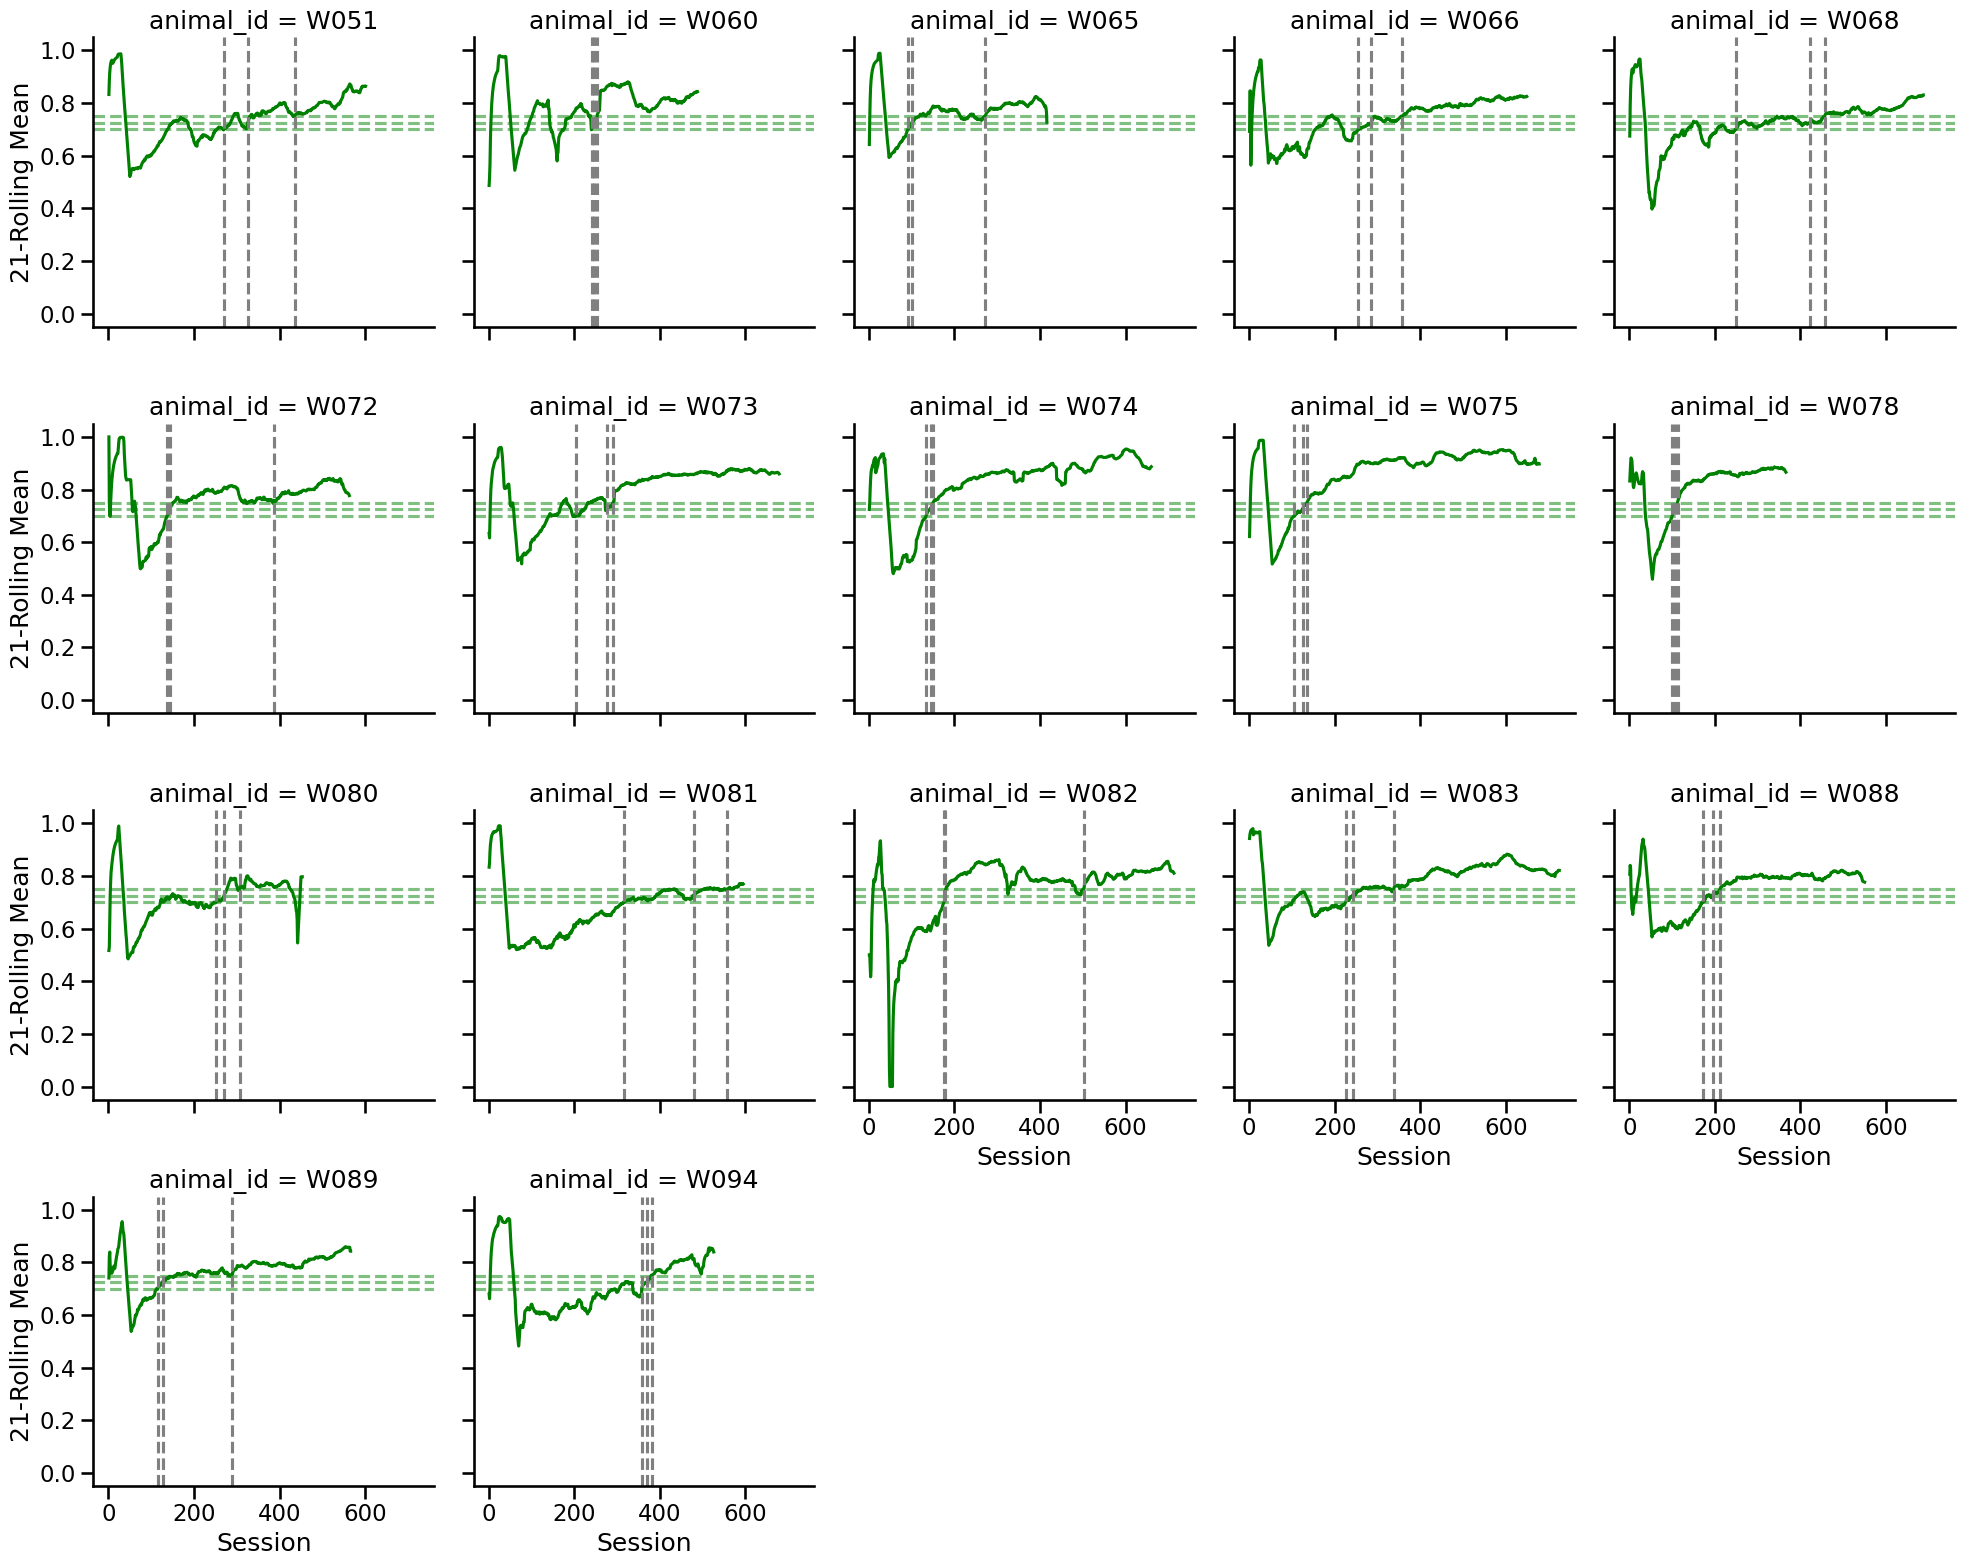

In [10]:
hit_rolling_mean = pt.data_dict["hit"]["rolling_mean_windows_df"].query(
    "window_size == @window_size"
)
filter_threshold = [0.70, 0.725, 0.75]

# # Create the facet grid plot

g = sns.FacetGrid(
    data=hit_rolling_mean,
    col="animal_id",
    col_wrap=5,
    height=4,
)
g.map(sns.lineplot, "session", "rolling_mean_hit", color="green")
g.map(plt.axhline, y=0.7, color="green", linestyle="--", alpha=0.5)
g.map(plt.axhline, y=0.725, color="green", linestyle="--", alpha=0.5)
g.map(plt.axhline, y=0.75, color="green", linestyle="--", alpha=0.5)
for ii, ax in enumerate(g.axes.flat):
    for threshold in filter_threshold:
        threshold_df = (
            pt.data_dict["hit"]["crossing_thresholds_df"]
            .query("threshold == @threshold")
            .reset_index()
        )

        ax.axvline(
            x=threshold_df["max_cross_sess"][ii],
            color="gray",
            linestyle="--",
        )


g.set_axis_labels("Session", f"{window_size}-Rolling Mean")

**Conclusion**: the 7.25% threshold seems to be the best option. I think 0.75 is too aggressive and truncates too much of the data.

The next step here is to look at violation rates in a similar manner. I want to see if they rise at all over training.


## Violations


In [11]:
_ = pt.compute_rolling_means_iter_window(df, "violation", window_sizes=[7, 14, 21, 28])

pt.data_dict["violation"]["rolling_mean_windows_df"].head()

,animal_id,session,training_stage,violation,rolling_mean_violation,window_size
0,W051,1,1,0.034946,0.034946,7
1,W051,2,1,0.461255,0.248100,7
2,W051,3,1,0.233010,0.243070,7
3,W051,4,1,0.207493,0.234176,7
4,W051,5,1,0.131054,0.213551,7


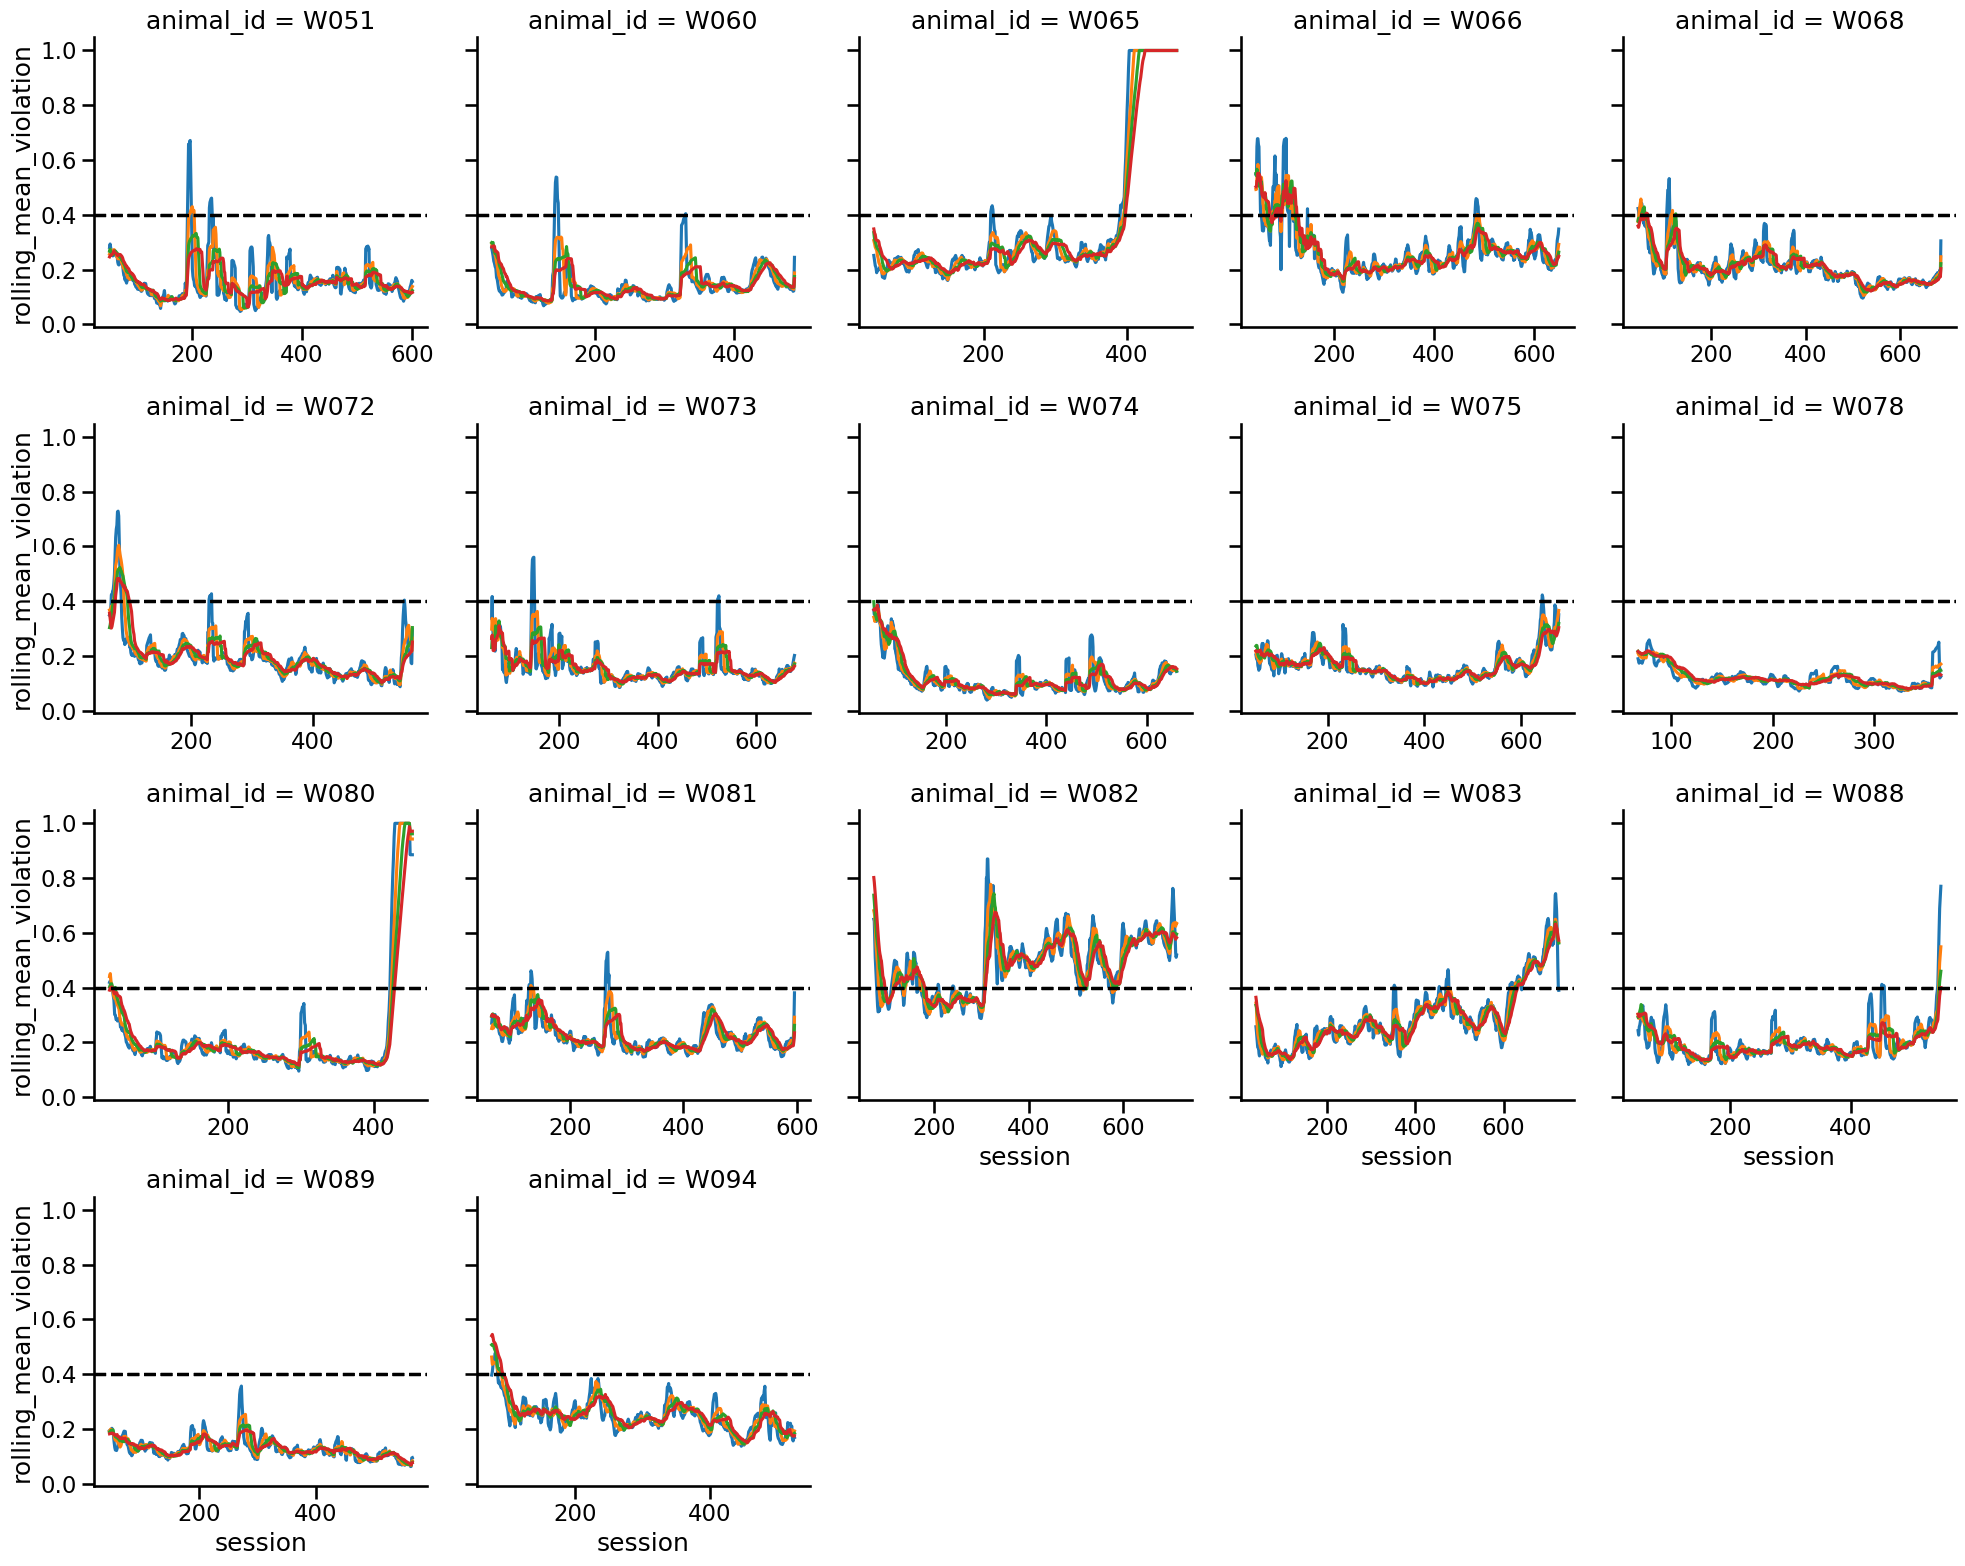

In [12]:
g = sns.FacetGrid(
    data=pt.data_dict["violation"]["rolling_mean_windows_df"].query(
        "training_stage > 3"
    ),
    col="animal_id",
    col_wrap=5,
    hue="window_size",
    height=4,
    sharex=False,
)
g.map(sns.lineplot, "session", "rolling_mean_violation")
g.map(plt.axhline, y=0.4, color="black", linestyle="--")

The rolling mean on violation rates seems to track well. I am noticing that two or three of the animals have sharp peaks in violations near the end of their training. I'd like to truncate those off. To be sensitive to when that rise is happening, I will likely want a shorter filter. The 7 day filter (blue) will be best for this.

I'm not as worried about high violation rates if they have been high throughout training. Moreover, if they start to rise (eg. `W083`) but the hit rate stays stable, I also do not think the data needs to be truncated.

**Next step**: Lets see if the last crossing over the 50% threshold is a good metric for truncating animals with a violation peak.


In [13]:
threshold = 0.50
window_size = 7
column = "violation"
viol_50_threshold = pt.calculate_threshold_crossings(
    df=pt.data_dict[column]["rolling_mean_windows_df"],
    column=column,
    window_size=window_size,
    threshold=threshold,
)

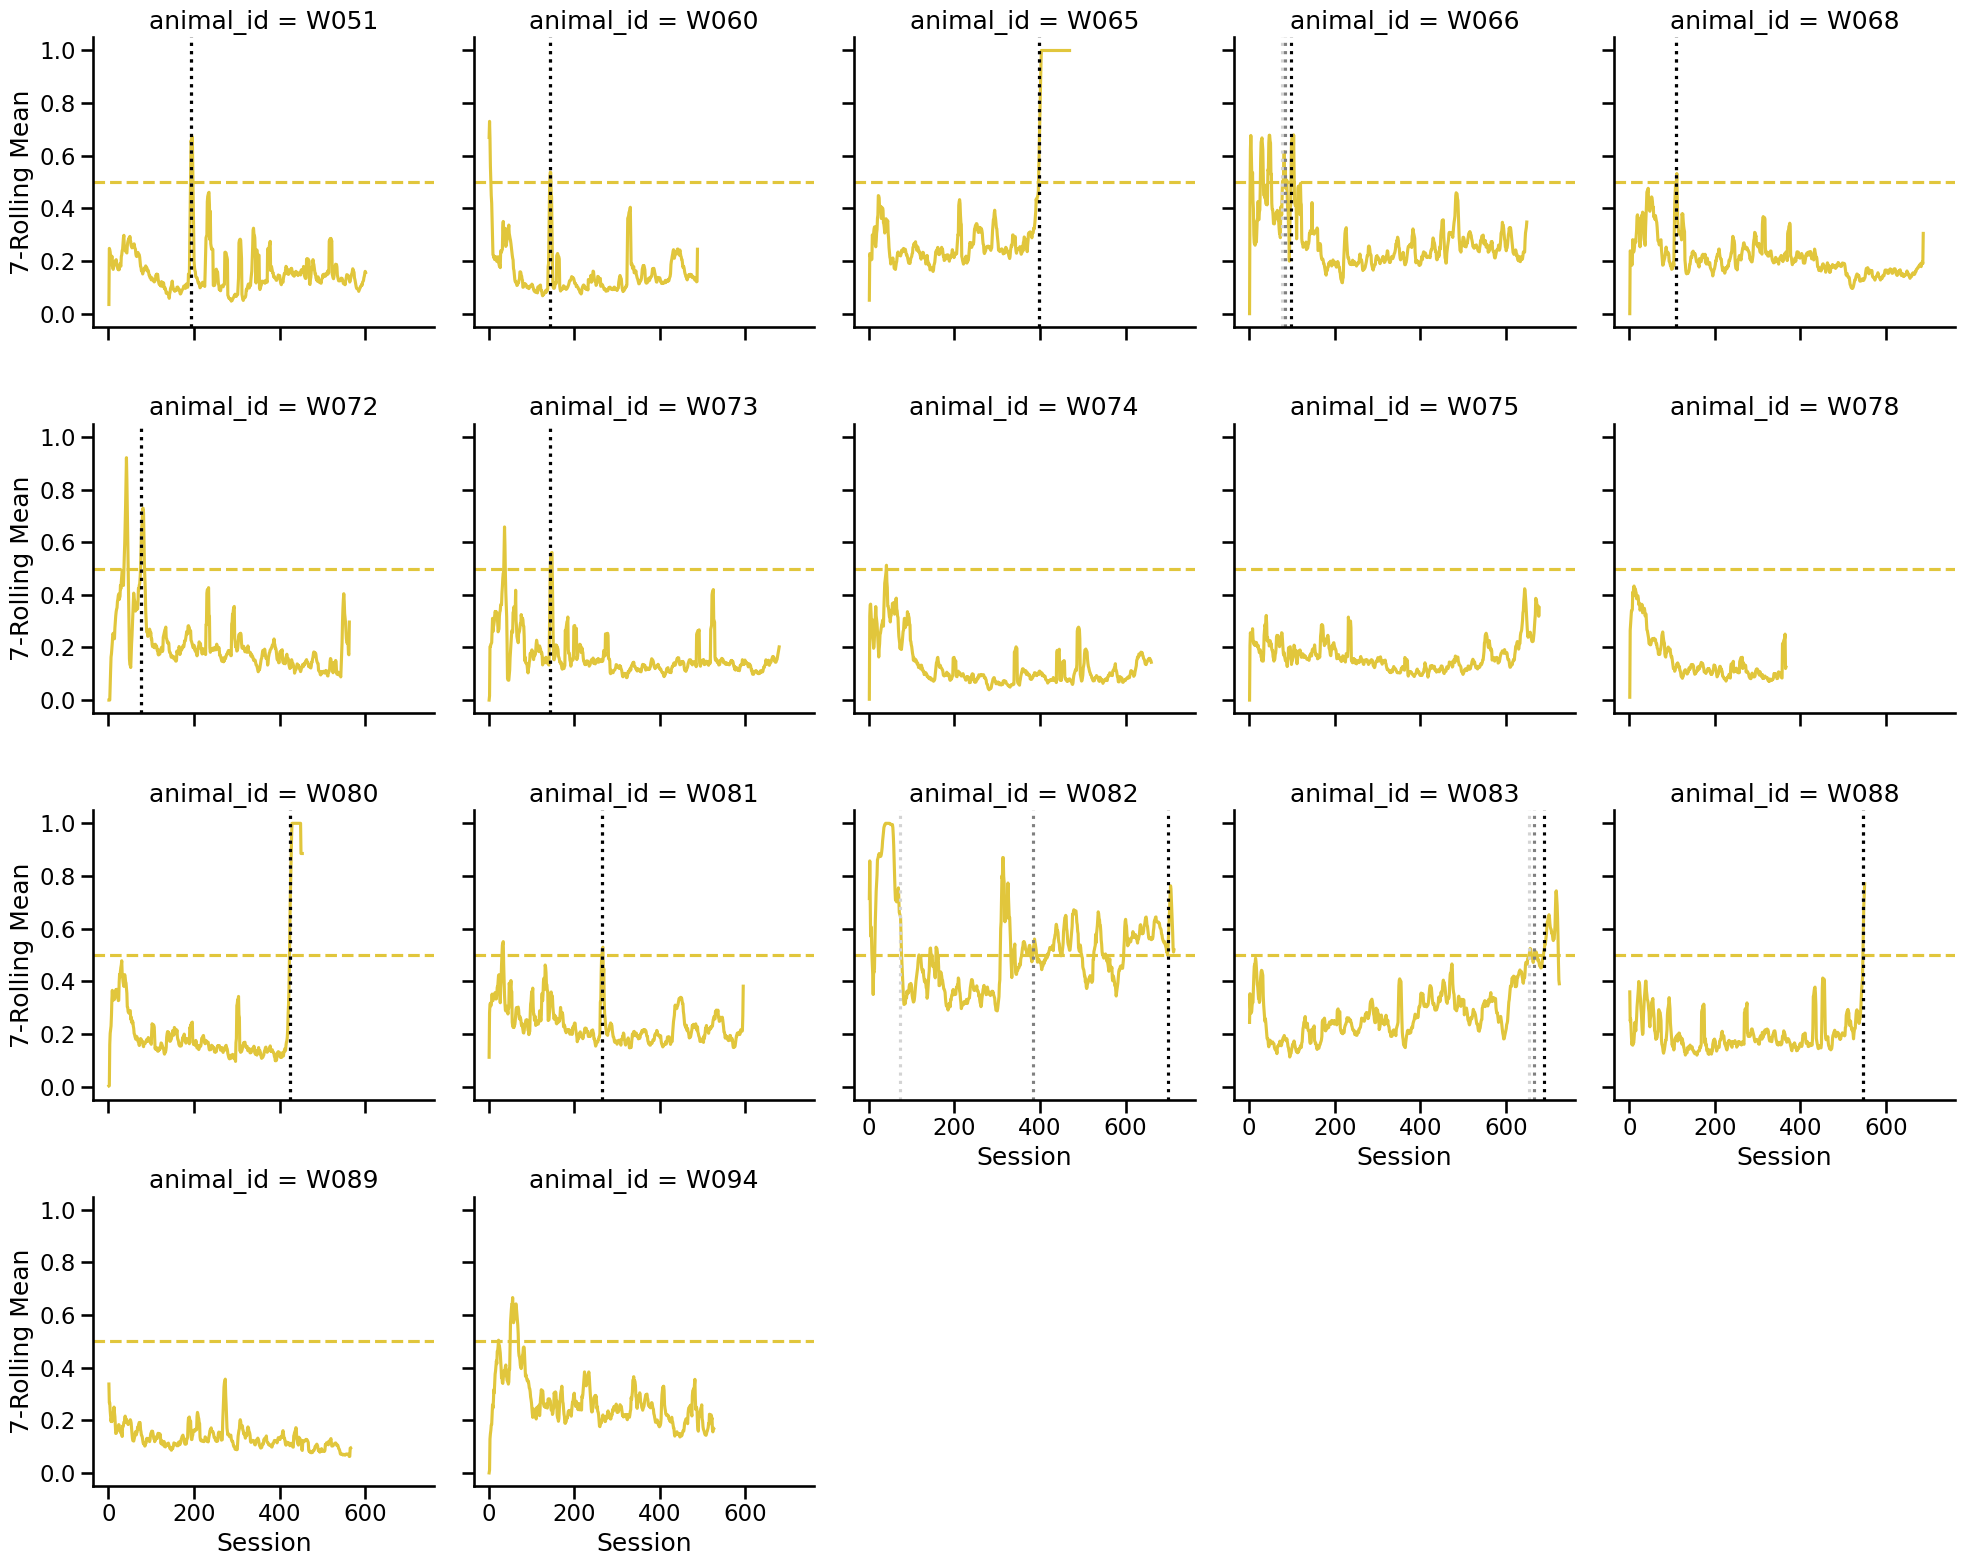

In [20]:
violation_rolling_mean = pt.data_dict[column]["rolling_mean_windows_df"].query(
    "window_size == @window_size"
)

# # Create the facet grid plot

g = sns.FacetGrid(
    data=violation_rolling_mean,
    col="animal_id",
    col_wrap=5,
    height=4,
)
g.map(sns.lineplot, "session", f"rolling_mean_{column}", color=c.VIOLATION_COLOR)
g.map(plt.axhline, y=threshold, color=c.VIOLATION_COLOR, linestyle="--")


for ii, ax in enumerate(g.axes.flat):
    ax.axvline(
        x=viol_50_threshold["min_cross_sess"][ii], color="lightgray", linestyle=":"
    )
    ax.axvline(x=viol_50_threshold["med_cross_sess"][ii], color="gray", linestyle=":")
    ax.axvline(x=viol_50_threshold["max_cross_sess"][ii], color="black", linestyle=":")

g.set_axis_labels("Session", f"{window_size}-Rolling Mean")

The animals I definitely truncate are W065, W080, W088. The rest of the animals I would need to look at the corresponding hit rate. I don't think I need to fine tune a threshold here- 50% seems sensible.

I want to look at the hit-viol plot for W062, W075, W083


In [21]:
violation_thresholds = [0.5]
column = "violation"

_ = pt.compute_crossings_iter_thresholds(
    df=pt.data_dict[column]["rolling_mean_windows_df"],
    column=column,
    window_size=window_size,
    thresholds=violation_thresholds,
)

pt.data_dict[column]["crossing_thresholds_df"].head()

,animal_id,crossed_threshold_count,threshold,min_cross_sess,med_cross_sess,max_cross_sess,window_size,type
0,W051,1,0.5,192.0,192.0,192.0,7,violation
1,W060,1,0.5,143.0,143.0,143.0,7,violation
2,W065,1,0.5,397.0,397.0,397.0,7,violation
3,W066,5,0.5,78.0,84.0,98.0,7,violation
4,W068,1,0.5,110.0,110.0,110.0,7,violation


### Hits & Violation

Lets start by creating a single rolling means data frame with the hit and violation data for the window size that was best for the variable (7 for viol, 21 for hit).


In [22]:
pt.data_dict["hit"]["window_size"] = 21

hit_rolling_mean_df = pt.data_dict["hit"]["rolling_mean_windows_df"].query(
    "window_size == @pt.data_dict['hit']['window_size']"
)
pt.data_dict["violation"]["window_size"] = 7
violation_rolling_mean_df = pt.data_dict["violation"]["rolling_mean_windows_df"].query(
    "window_size == @pt.data_dict['violation']['window_size']"
)

hit_viol_rolling_means = pd.merge(
    hit_rolling_mean_df.reset_index(drop=True),
    violation_rolling_mean_df.reset_index(drop=True),
    on=["animal_id", "session", "training_stage"],
    suffixes=("_hit", "_violation"),
).query("training_stage > 3")

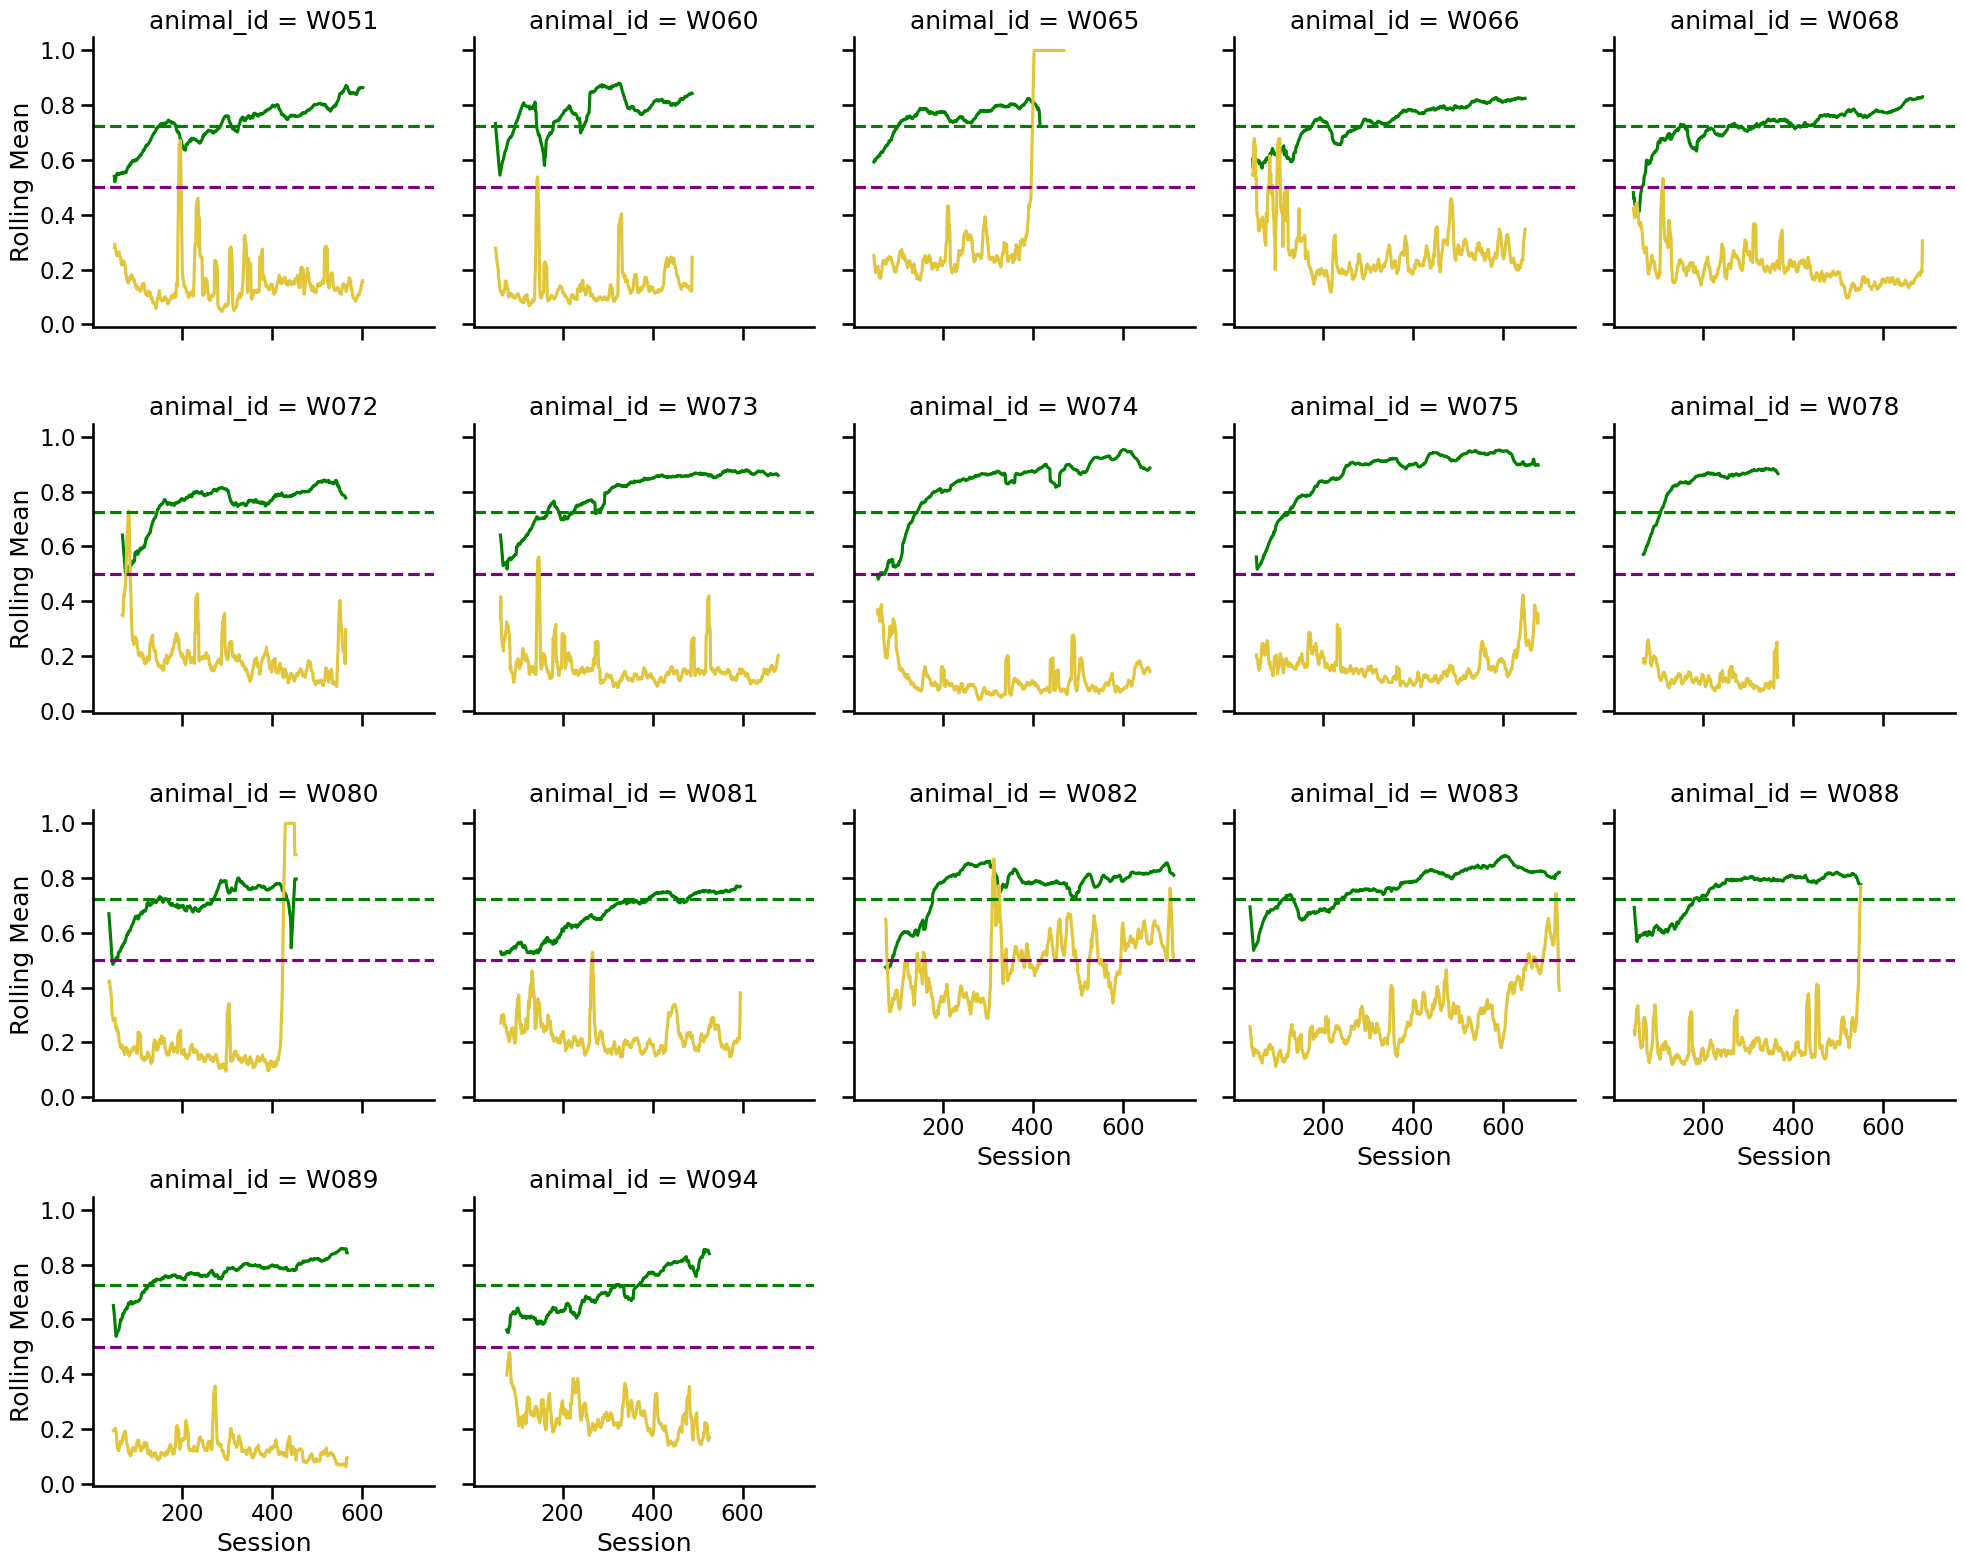

In [23]:
g = sns.FacetGrid(
    data=hit_viol_rolling_means.query("training_stage > 3"),
    col="animal_id",
    col_wrap=5,
    height=4,
    sharex=True,
)
g.map(sns.lineplot, "session", "rolling_mean_hit", color=c.HIT_COLOR)
g.map(sns.lineplot, "session", "rolling_mean_violation", color=c.VIOLATION_COLOR)
g.map(plt.axhline, y=0.725, color="green", linestyle="--")
g.map(
    plt.axhline,
    y=0.5,
    color="purple",
    linestyle="--",
)
g.set_axis_labels("Session", f"Rolling Mean")

Okay- seems like some truncation could be good here-

W065, W080, W088 are definite yes

W075 is still performing well above 80% correct

W082 has a high violation rate throughout and no clear change in hit rate

W083 is still performing well but did over 600 sessions so might as well truncate a few of them.

So the final animals who will get truncated due to the last crossing above the 50% violation threshold are: `W065`, `W080`, `W083`, `W088`.


In [24]:
# Pull out df with thresholds of choice
pt.data_dict["hit"]["threshold"] = 0.725
hit_threshold_df = pt.data_dict["hit"]["crossing_thresholds_df"].query(
    "threshold == @pt.data_dict['hit']['threshold']"
)

pt.data_dict["violation"]["threshold"] = 0.5
violation_threshold_df = pt.data_dict["violation"]["crossing_thresholds_df"].query(
    "threshold == @pt.data_dict['violation']['threshold']"
)


# Create merged df & rename columns
hit_viol_threshold_df = hit_threshold_df[["animal_id", "max_cross_sess"]].merge(
    violation_threshold_df[["animal_id", "max_cross_sess"]],
    on="animal_id",
    suffixes=("_hit", "_viol"),
)

# Rename the columns
hit_viol_threshold_df.rename(
    columns={
        "max_cross_sess_hit": "hit_threshold",
        "max_cross_sess_viol": "violation_threshold",
    },
    inplace=True,
)

# Set violation threshold to nan for animals that don't appear to need it
# based on the eda above
apply_viol_threshold = ["W065", "W080", "W083", "W088"]
hit_viol_threshold_df.loc[
    ~hit_viol_threshold_df["animal_id"].isin(apply_viol_threshold),
    "violation_threshold",
] = None

hit_viol_threshold_df.head()

,animal_id,hit_threshold,violation_threshold
0,W051,325,NaN
1,W060,247,NaN
2,W065,100,397.0
3,W066,285,NaN
4,W068,422,NaN


Great- now we have everything all together. Let's plot the data and put gray shading over data that meets the criteria. Specifically, data after the hit threshold for the animal and before the violation threshold (if applicable).


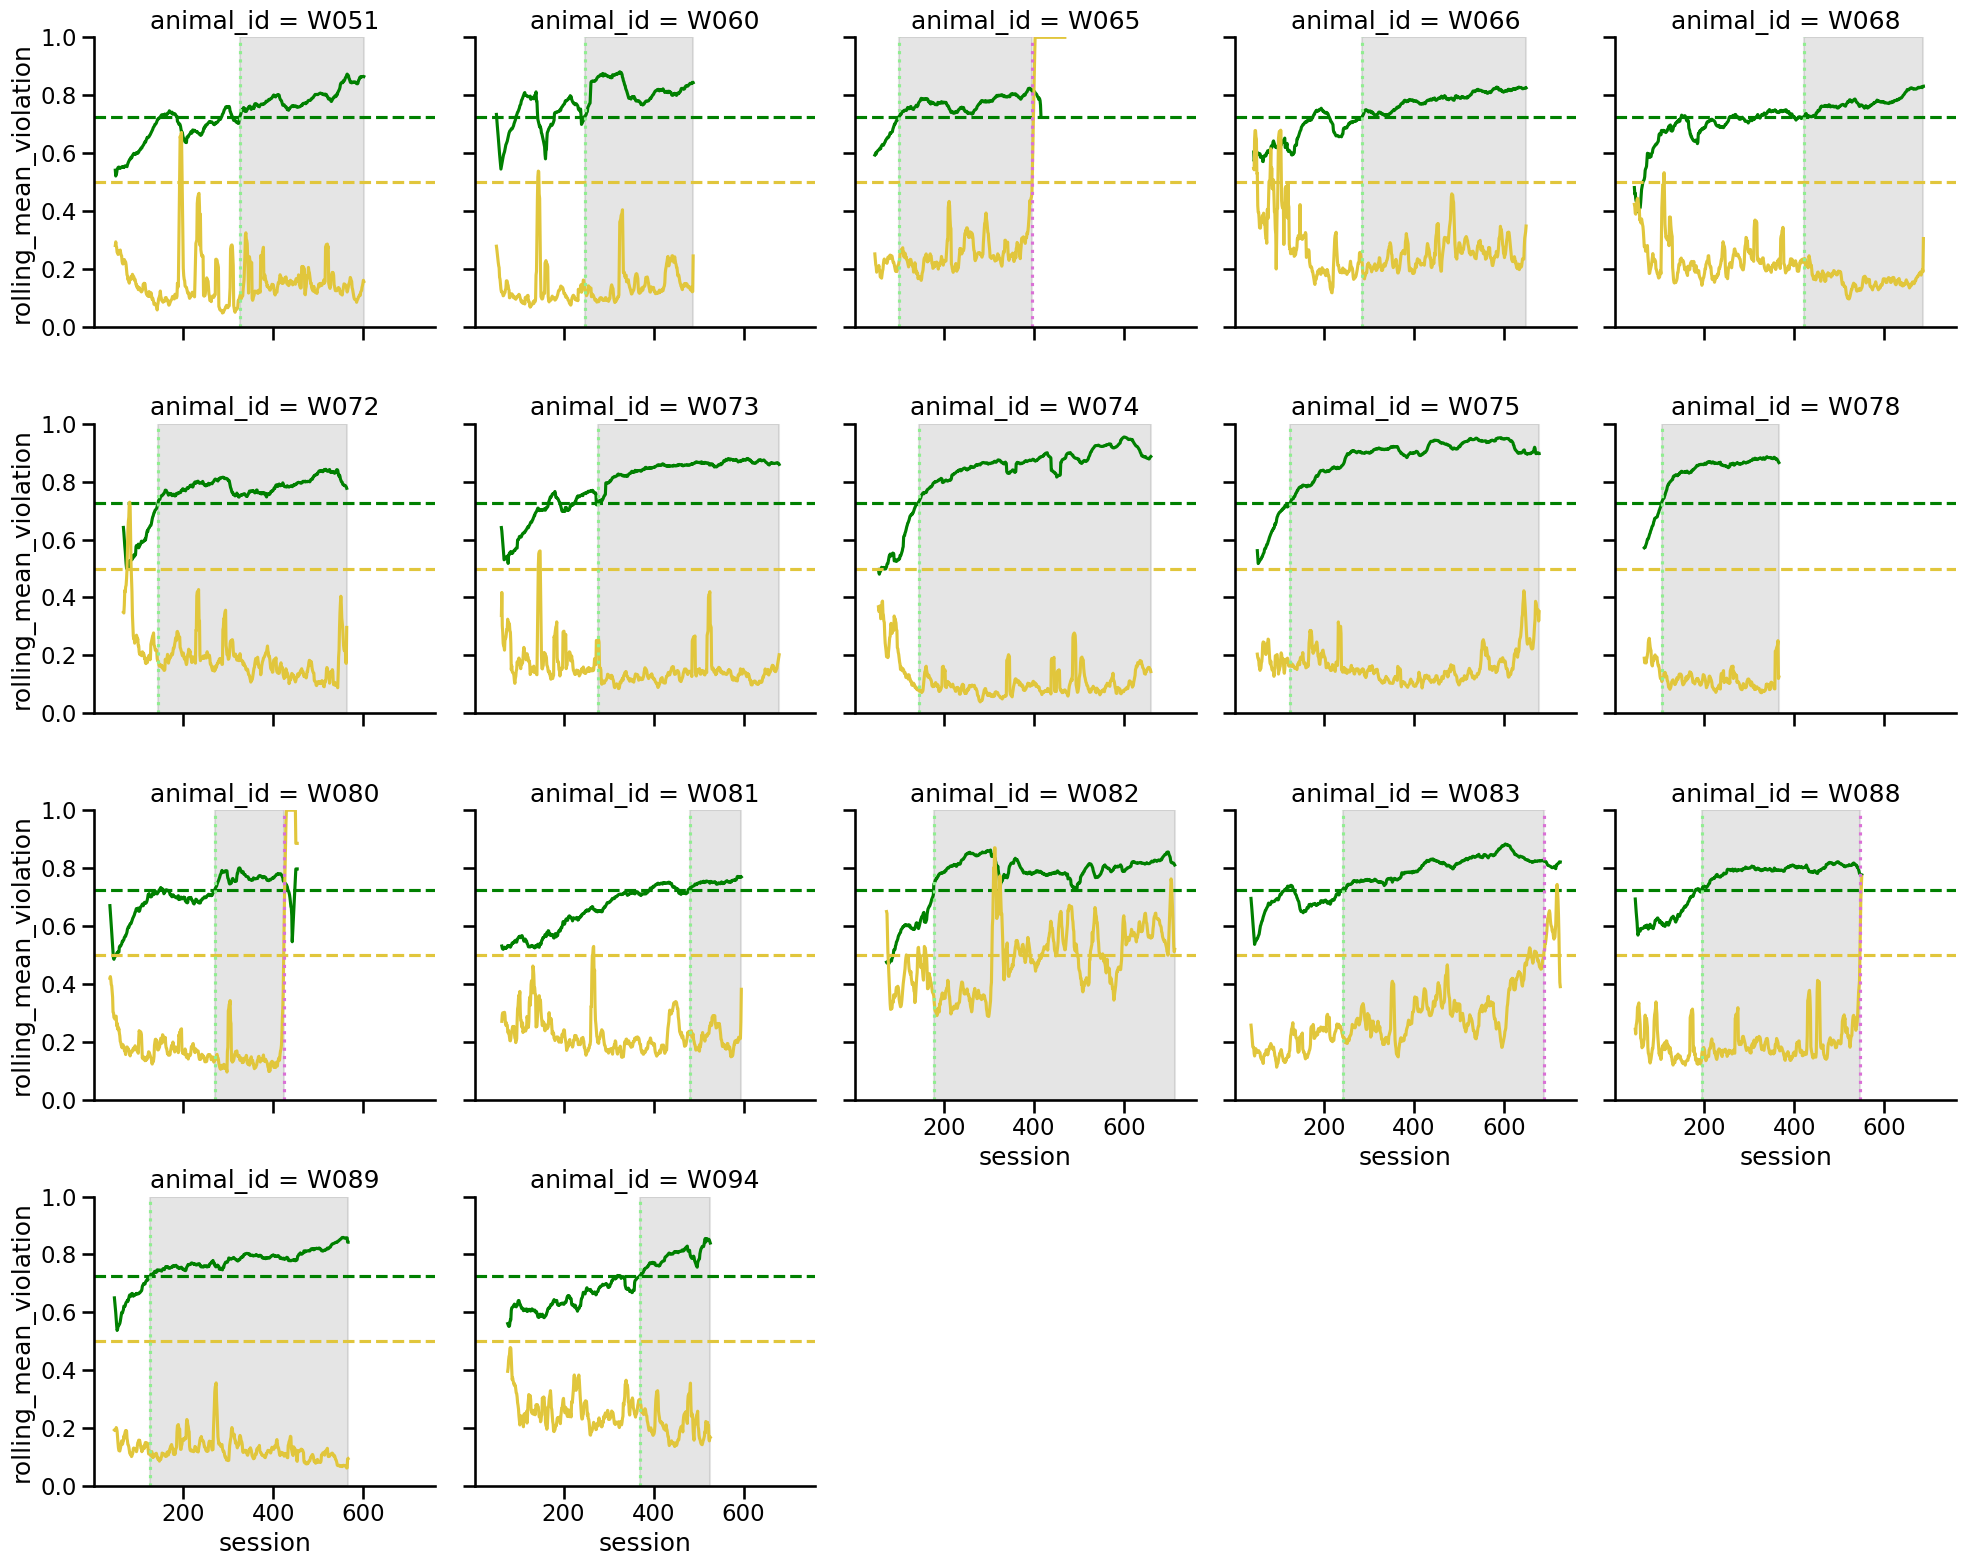

In [26]:
g = sns.FacetGrid(
    data=hit_viol_rolling_means.query("training_stage > 3"),
    col="animal_id",
    col_wrap=5,
    height=4,
    ylim=(0, 1),
)
g.map(sns.lineplot, "session", "rolling_mean_hit", color=c.HIT_COLOR)
g.map(plt.axhline, y=pt.data_dict["hit"]["threshold"], color=c.HIT_COLOR, linestyle="--")

g.map(sns.lineplot, "session", "rolling_mean_violation", color=c.VIOLATION_COLOR)
g.map(
    plt.axhline,
    y=pt.data_dict["violation"]["threshold"],
    color=c.VIOLATION_COLOR,
    linestyle="--",
)


# Assuming hit_viol_threshold_df and g are already defined
for ii, ax in enumerate(g.axes.flat):
    hit_threshold = hit_viol_threshold_df["hit_threshold"][ii]
    violation_threshold = hit_viol_threshold_df["violation_threshold"][ii]
    animal_id = hit_viol_threshold_df["animal_id"][ii]

    if animal_id in ["W061", "W062"]:
        continue

    # Draw the first axvline for hit_threshold
    ax.axvline(x=hit_threshold, color="lightgreen", linestyle=":")

    if pd.notna(violation_threshold):
        ax.axvline(x=violation_threshold, color="orchid", linestyle=":")
        # Use fill_between to shade the area between the two axvlines
        ax.fill_betweenx(
            ax.get_ylim(), hit_threshold, violation_threshold, color="grey", alpha=0.2
        )
    else:
        # If violation_threshold is None, shade to the end of the line
        # Determine the maximum x-axis value from your data or use a predefined max value
        # print("evaluating!")
        max_x_value = hit_viol_rolling_means.query(
            "animal_id == @animal_id"
        ).session.max()  # Or use a specific value based on your dataset
        ax.fill_betweenx(
            ax.get_ylim(), hit_threshold, max_x_value, color="grey", alpha=0.2
        )

g.savefig("figures/figS3_trained_thresholding.png", dpi=300, bbox_inches='tight')

I'm very happy with this- I feel good about all the data that is in the gray shaded region for all the animals. Now, I'd like to get some summary data for how many sessions and trials are present in this dataset.

To do this, I'm going to filter the cleaned data frame (`df`)to each animals specific hit and violation (if applicable) threshold and compute summary stats on it.


In [ ]:
# Stopped here- don't actually need to run this code/make df

In [20]:
def filter_sessions(group):
    hit_threshold = hit_viol_threshold_df.query(
        "animal_id == @group.name"
    ).hit_threshold.values[0]
    viol_threshold = hit_viol_threshold_df.query(
        "animal_id == @group.name"
    ).violation_threshold.values[0]
    if np.isnan(viol_threshold):
        return group.query("session > @hit_threshold")
    else:
        return group.query("session > @hit_threshold and session < @viol_threshold")

In [21]:
drop_animals = ["W061", "W062"]
filtered_df = (
    df.query("animal_id != @drop_animals")
    .groupby("animal_id")
    .apply(filter_sessions)
    .reset_index(drop=True)
)

In [22]:
filtered_summary_stats = (
    filtered_df.groupby("animal_id")
    .agg(
        n_trials=("hit", "count"),
        n_sessions=("session", "nunique"),
        avg_hit=("hit", "mean"),
        avg_violation=("violation", "mean"),
    )
    .reset_index()
)

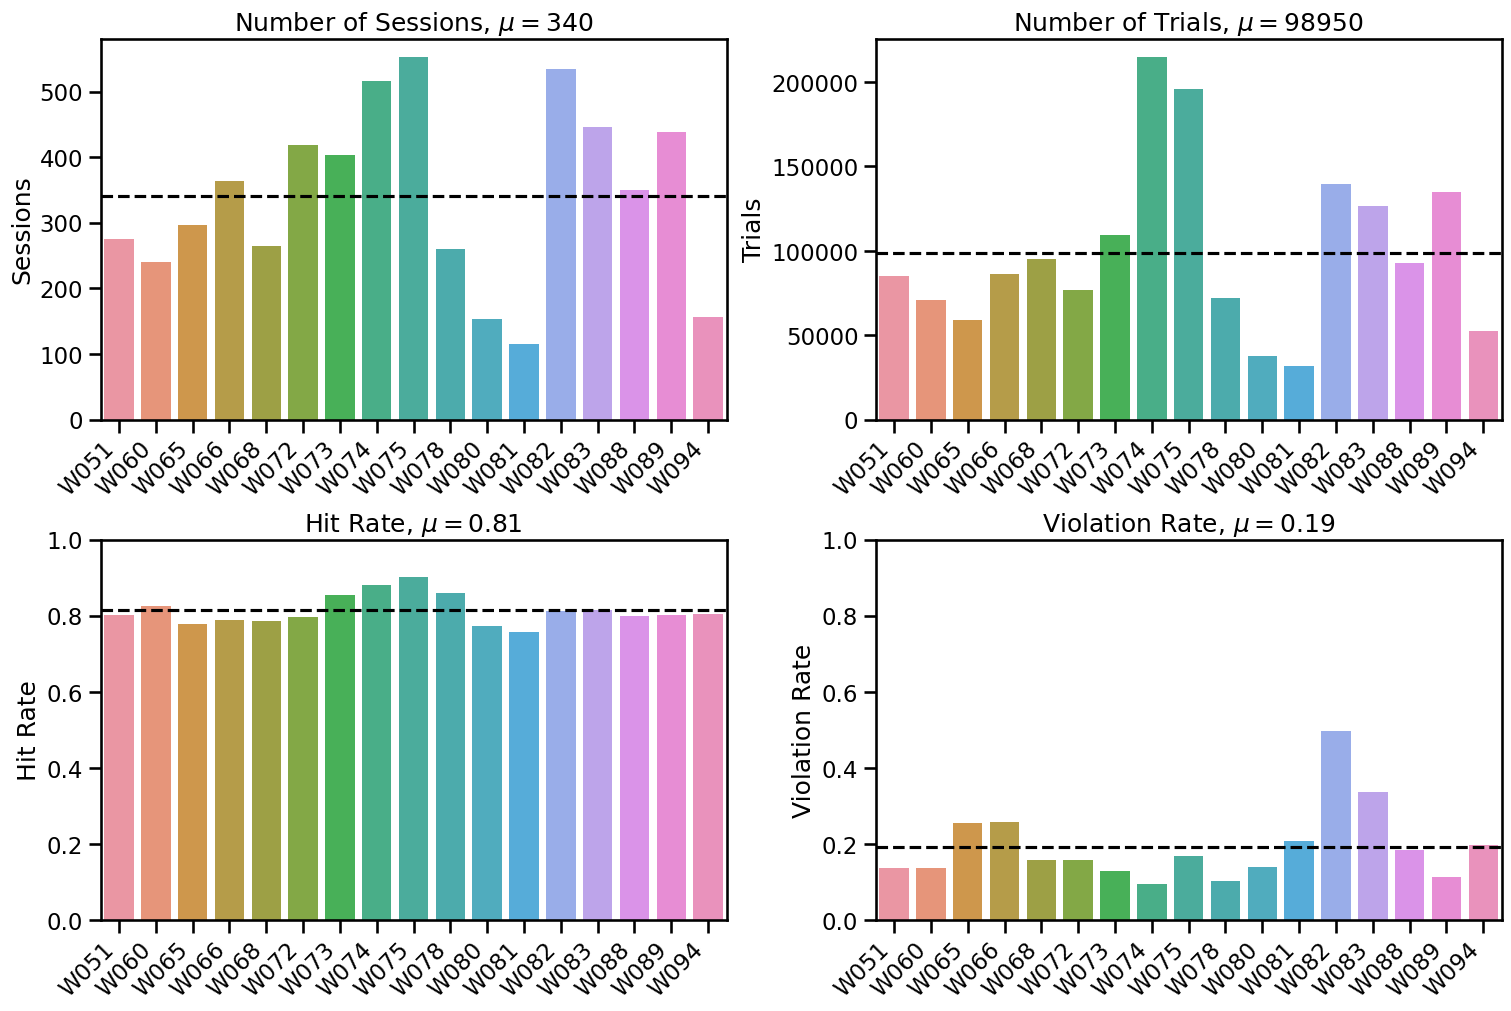

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True)


sns.barplot(x="animal_id", y="n_sessions", data=filtered_summary_stats, ax=ax[0, 0])
session_mean = filtered_summary_stats.n_sessions.mean()
ax[0, 0].axhline(session_mean, color="k", linestyle="--")
_ = ax[0, 0].set(
    title=f"Number of Sessions, $\mu = ${session_mean:.0f}",
    xlabel="",
    ylabel="Sessions",
)

sns.barplot(x="animal_id", y="n_trials", data=filtered_summary_stats, ax=ax[0, 1])
trials_mean = filtered_summary_stats.n_trials.mean()
ax[0, 1].axhline(trials_mean, color="k", linestyle="--")
_ = ax[0, 1].set(
    title=f"Number of Trials, $\mu= ${trials_mean:.0f}", xlabel="", ylabel="Trials"
)


sns.barplot(x="animal_id", y="avg_hit", data=filtered_summary_stats, ax=ax[1, 0])
hit_mean = filtered_summary_stats.avg_hit.mean()
ax[1, 0].axhline(hit_mean, color="k", linestyle="--")
_ = ax[1, 0].set(
    title=f"Hit Rate, $\mu = ${hit_mean:.2f}", xlabel="", ylabel="Hit Rate", ylim=(0, 1)
)

sns.barplot(x="animal_id", y="avg_violation", data=filtered_summary_stats, ax=ax[1, 1])
violation_mean = filtered_summary_stats.avg_violation.mean()
ax[1, 1].axhline(violation_mean, color="k", linestyle="--")
_ = ax[1, 1].set(
    title=f"Violation Rate, $\mu = ${violation_mean:.2f}",
    xlabel="",
    ylabel="Violation Rate",
    ylim=(0, 1),
)

for a in ax.flatten():
    _ = a.set_xticklabels(a.get_xticklabels(), rotation=45, ha="right")

## Performance by Stim


In [24]:
def plot_animal_performance_by_stim(df, ax=None, labels=False):

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    stim_table = (
        df.groupby(["s_a", "s_b"])
        .agg(perf_rate=("hit", "mean"), perf_count=("hit", "size"))
        .reset_index()
    )

    scatter_sizes = stim_table.perf_count / 100

    # plot each sa,sb pair with rate as color
    scatter = ax.scatter(
        stim_table.s_a,
        stim_table.s_b,
        c=stim_table.perf_rate,
        cmap="flare",
        vmin=0,
        vmax=1,
        marker=",",
        s=scatter_sizes,
    )

    ax.axline(xy1=(60, 60), slope=1, color="lightgray", linestyle="--")
    # Add a colorbar to the plot
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("hit rate")

    # add labels to each point
    if labels:
        for i, txt in enumerate(stim_table.perf_rate):
            ax.text(
                stim_table.s_a[i] - 2,
                stim_table.s_b[i] + 1.5,
                f"{round(txt, 2)} [{stim_table.perf_count[i]}]",
                fontsize=8,
            )

    return None

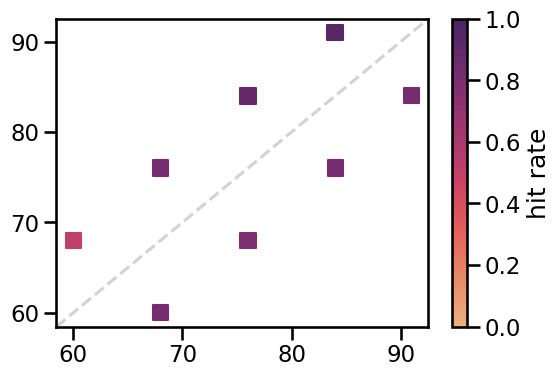

In [25]:
plot_animal_performance_by_stim(filtered_df.query("animal_id == 'W051'"))

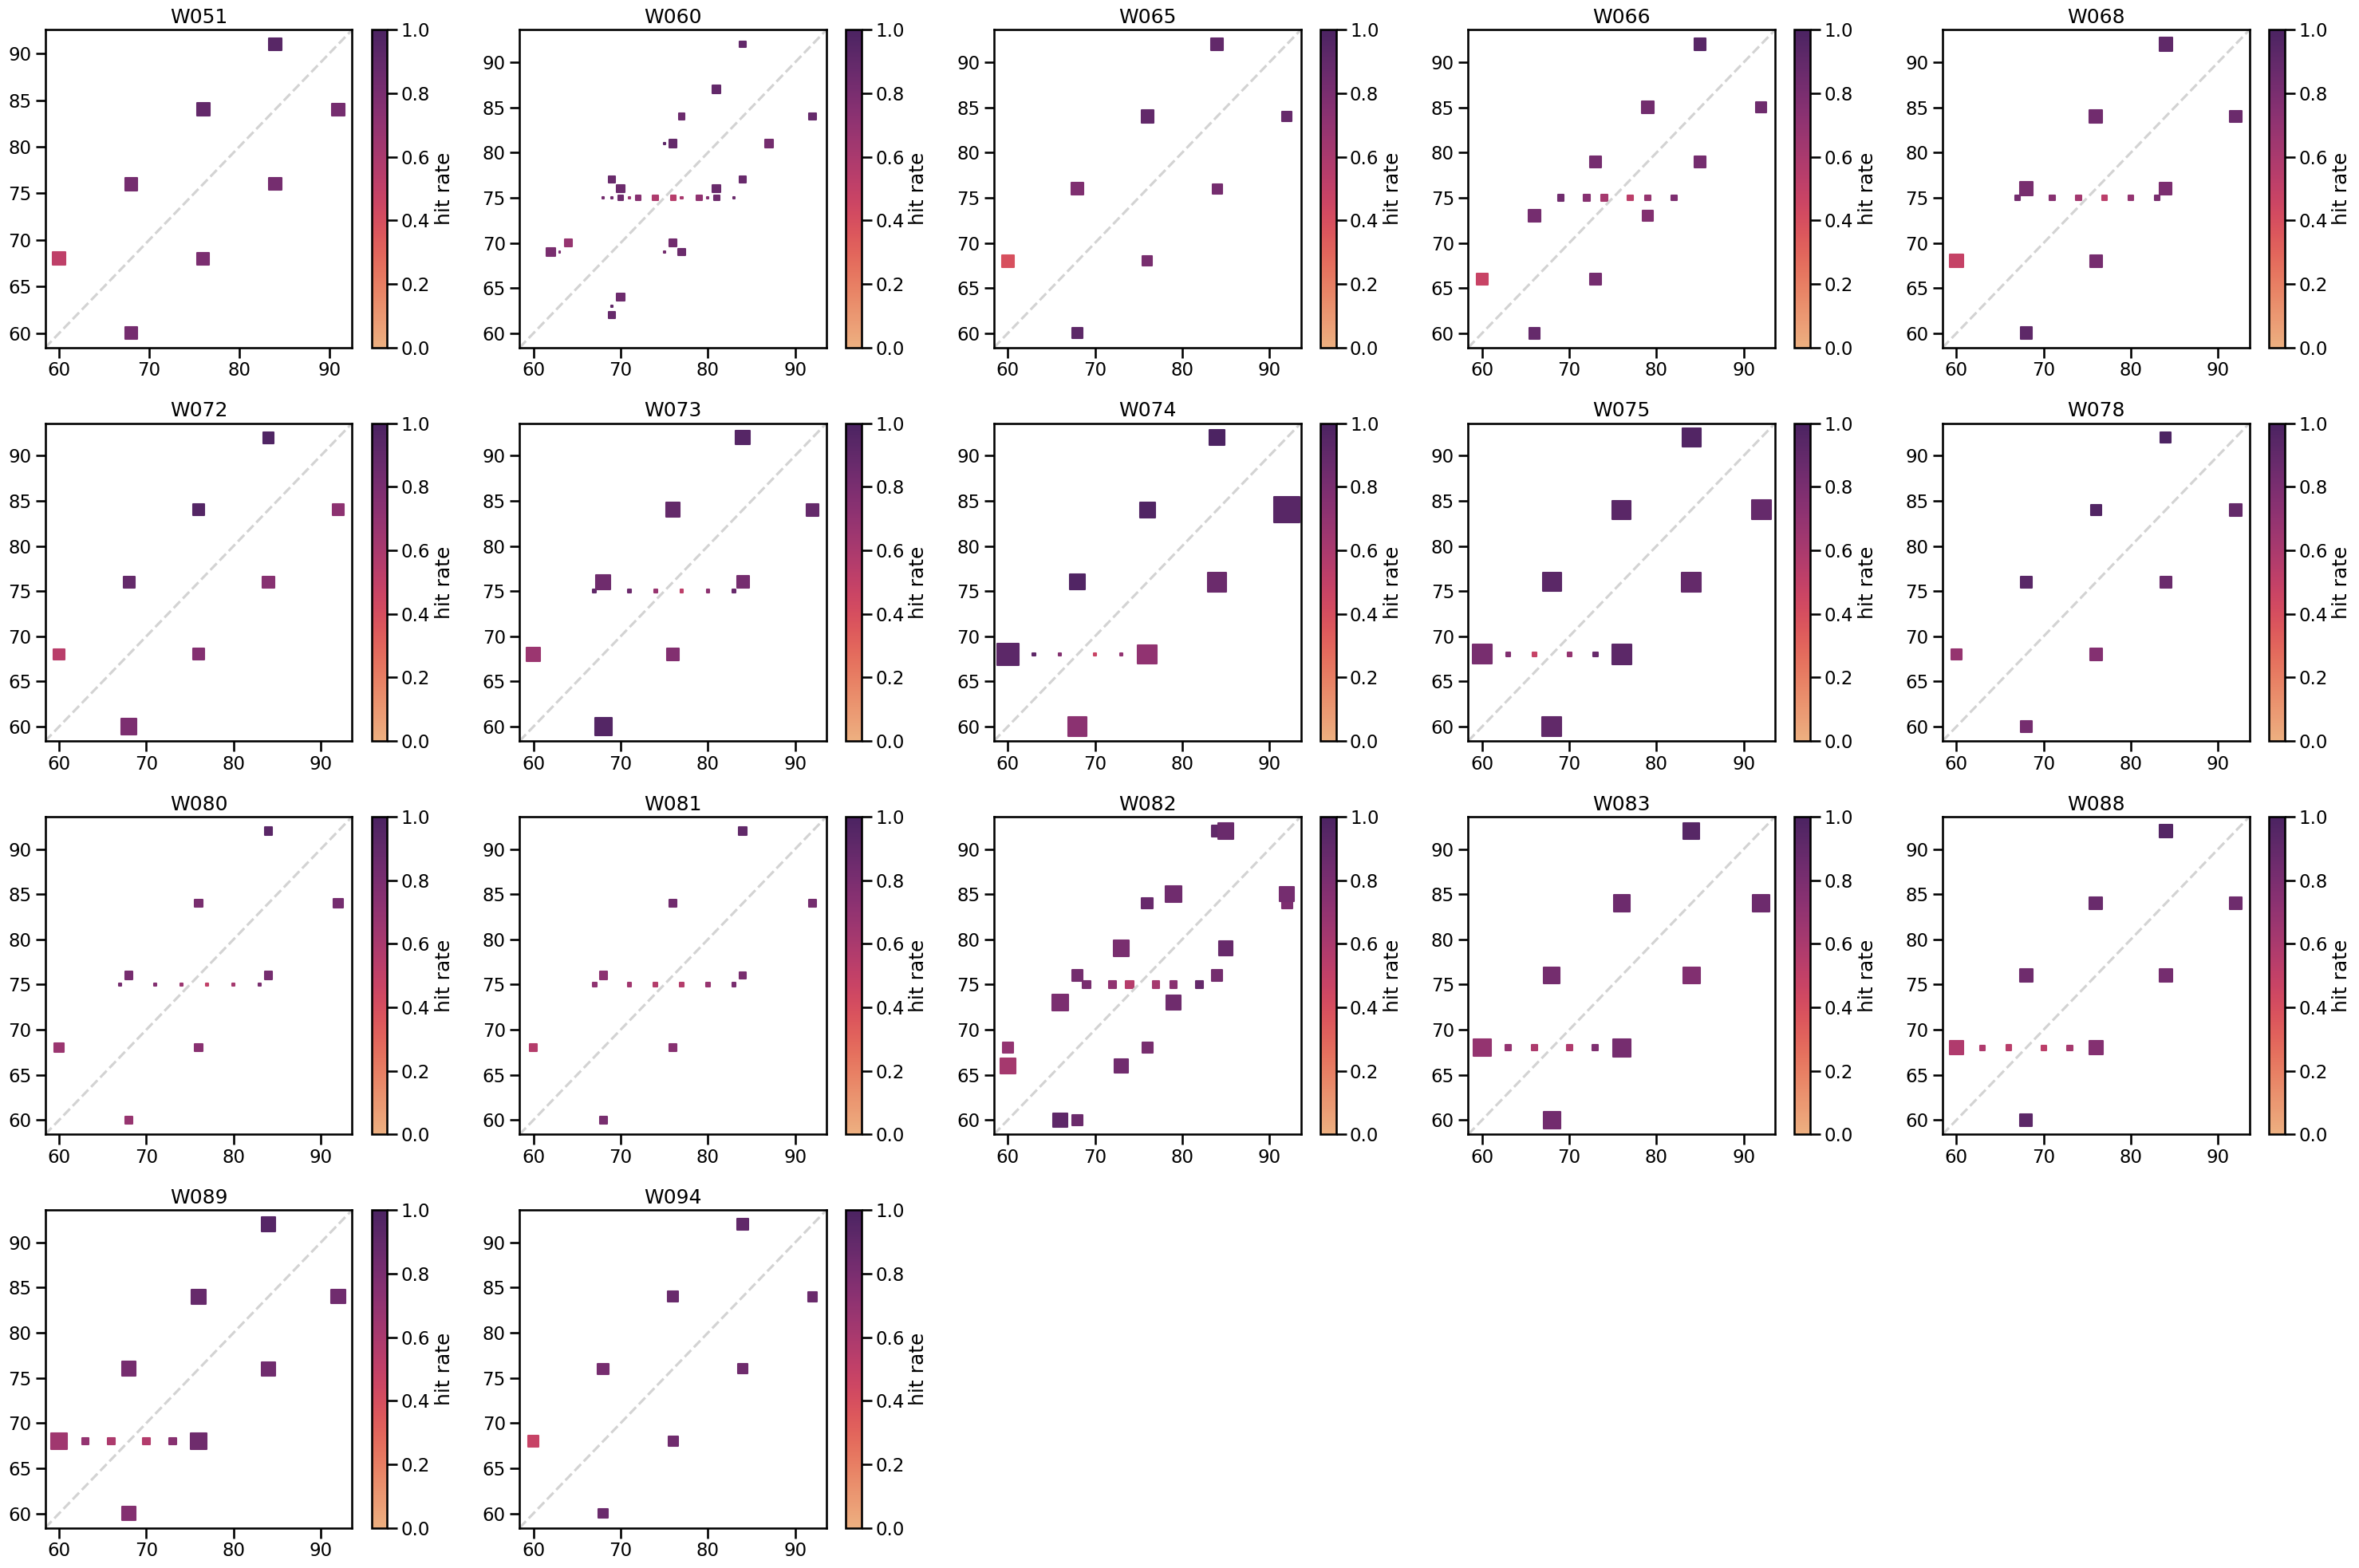

In [26]:
n_animals = filtered_df.animal_id.nunique()
n_rows = 4
n_cols = 5
fig, ax = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))

# Plot- iterate over grid
for ii, (animal_id, sub_df) in enumerate(filtered_df.groupby("animal_id")):

    row_idx, col_idx = np.unravel_index(ii, (n_rows, n_cols))

    current_ax = ax[row_idx, col_idx] if n_rows > 1 else ax[col_idx]

    plot_animal_performance_by_stim(sub_df, current_ax)

    current_ax.set(title=animal_id)

# Remove empty subplots if the number of animals doesn't fill the entire grid
for ax_idx in range(n_animals, n_rows * n_cols):
    if n_rows > 1:
        fig.delaxes(ax.flatten()[ax_idx])
    else:
        fig.delaxes(ax[ax_idx])

plt.tight_layout()
plt.show()

## Save Out


In [ ]:
assert False

In [27]:
## save out data frames
filtered_df.to_csv("../data/processed/all_animals_trained_threshold.csv", index=False)

hit_viol_rolling_means.to_csv(
    "../data/processed/dataset_thresholding/hit_21_viol_7_rolling_means.csv",
    index=False,
)
hit_viol_threshold_df.to_csv(
    "../data/processed/dataset_thresholding/threshold_sessions.csv", index=False
)
filtered_summary_stats.to_csv(
    "../data/processed/dataset_thresholding/trained_threshold_df_stats.csv"
)

## save out data dict
with open("../data/processed/dataset_thresholding/threshold_data_dict.pkl", "wb") as f:
    pickle.dump(pt.data_dict, f)

## 2024-06-25 edit

I've been having issues with loading large `.csv` files from Cup when running and testing experiments locally, so I am converting the `trained_threshold`df (which is the most commonly used one) to a compressed `.parquet` file. This changed read-in time from 1 min 20 seconds to 8 seconds.

Additionally, I added a unique column for animal, session pairs


In [4]:
trained_threshold_data = pd.read_csv(
    "../../../data/processed/all_animals_trained_threshold.csv"
)
trained_threshold_data

In [9]:
trained_threshold_data["animal_id_session"] = (
    trained_threshold_data["animal_id"].astype(str)
    + "_s"
    + trained_threshold_data["session"].astype(str)
)

In [31]:
trained_threshold_data.to_csv(
    "../../../data/processed/all_animals_trained_threshold.csv", index=False
)


parquet_file_path = "../../../data/processed/all_animals_trained_threshold.parquet"
parquet_cup_file = "/Volumes/brody/jbreda/behavioral_analysis/violations_multinomial/data/processed/all_animals_trained_threshold.parquet"

trained_threshold_data.to_parquet(parquet_file_path, engine="pyarrow")
trained_threshold_data.to_parquet(parquet_cup_file, engine="pyarrow")

In [9]:
pd.read_parquet(parquet_cup_file)

,animal_id,session_date,session_file_counter,rig_id,training_stage,s_a,s_b,hit,violation,trial_not_started,...,l_water_vol,r_water_vol,antibias_beta,antibias_right_prob,using_psychometric_pairs,choice,session,session_relative_to_old,n_prev_trial_not_started,trial
0,W051,2014-07-17,327,19,4,60.0,68.0,NaN,1,False,...,18.000000,18.000000,3,0.500000,NaN,2,326,326.0,0.0,1
1,W051,2014-07-17,327,19,4,60.0,68.0,NaN,1,False,...,18.000001,18.000001,3,0.500000,NaN,2,326,326.0,0.0,2
2,W051,2014-07-17,327,19,4,76.0,68.0,NaN,1,False,...,18.000004,18.000004,3,0.500000,NaN,2,326,326.0,0.0,3
3,W051,2014-07-17,327,19,4,68.0,76.0,1.0,0,False,...,18.000014,18.000014,3,0.500000,NaN,0,326,326.0,0.0,4
4,W051,2014-07-17,327,19,4,84.0,76.0,1.0,0,False,...,18.000033,18.000033,3,0.500000,NaN,1,326,326.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144770,W094,2016-09-01,526,5,4,60.0,68.0,NaN,1,False,...,37.334785,37.334785,3,0.471529,0.0,2,526,463.0,0.0,1490
2144771,W094,2016-09-01,526,5,4,60.0,68.0,NaN,1,False,...,37.335700,37.335700,3,0.471529,0.0,2,526,463.0,0.0,1491
2144772,W094,2016-09-01,526,5,4,84.0,92.0,1.0,0,False,...,37.336613,37.336613,3,0.471529,0.0,0,526,463.0,0.0,1492
2144773,W094,2016-09-01,526,5,4,68.0,76.0,0.0,0,False,...,37.337525,37.337525,3,0.476910,0.0,1,526,463.0,0.0,1493
